### THEATRICAL GROSS CLUSTERS
create clusters based on predictive metrics
- wiki views
- seasonality
- genre

Clusters will inform auto-gluon time series prediction

In [1]:
import pandas as pd
import re
import datetime as dt
import numpy as np

import matplotlib.pyplot as plot

### create connection

In [2]:
def get_prediction_week(relative_weeks=None):

    if relative_weeks:
        date_str = (dt.date.today() - dt.timedelta(weeks=relative_weeks)).strftime('%Y-%m-%d')
        
    else:
        date_str = dt.date.today().strftime('%Y-%m-%d')
            
    fri_delta = 4 - pd.to_datetime(date_str).weekday()
        
    date_str = (pd.to_datetime(date_str) + dt.timedelta(days=fri_delta)).strftime('%Y-%m-%d')
    file_str = pd.to_datetime(date_str).strftime('%Y_%m_%d')
    
    return date_str, file_str

In [4]:
prediction_week, file_str = get_prediction_week()
print(prediction_week)

# prediction_week = '2024-11-01'
# prediction_week

2025-05-09


### pull training data

In [5]:
wiki_final_metrics_all = pd.read_csv('wiki_signals_mapped_2025-05-10.csv')


print(wiki_final_metrics_all.title.nunique())
print(wiki_final_metrics_all.shape)
wiki_final_metrics_all.head(3)

868
(152861, 30)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor,dist_category,covid
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,99.00,3.707506e-07,0.0,0.0,99.0,99.0,0.0,Paramount Pictures,major,pre_covid
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,99.50,3.689283e-07,0.0,0.0,149.0,199.0,0.0,Paramount Pictures,major,pre_covid
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,...,96.33,3.574322e-07,0.0,0.0,179.0,289.0,0.0,Paramount Pictures,major,pre_covid


In [6]:
wiki_final_metrics_all['release_date'] = pd.to_datetime(wiki_final_metrics_all['release_date'])
wiki_final_metrics_all['wiki_date'] = pd.to_datetime(wiki_final_metrics_all['wiki_date'])

In [7]:
wiki_final_metrics_all['title_id'] = wiki_final_metrics_all['title_id'].astype(str)

In [8]:
wiki_final_metrics_all['release_date'].max()

Timestamp('2025-02-07 00:00:00')

In [12]:
## remove missing week gross
# wiki_final_metrics_all[wiki_final_metrics_all['week_gross_2'] != 0].copy()

In [9]:
wiki_final_metrics_all.columns

Index(['title', 'title_id', 'release_date', 'wiki_date', 'view_count',
       'daily_page_count_views', 'tot_page_count_views', 'edits',
       'abs_bytes_diff', 'rigor', 'user_count', 'daily_page_count_edits',
       'tot_page_count_edits', 'tot_views', 'runtime', 'budget_cleaned',
       'title_match', 'id', 'days_delta', 'views_prop', 'views_5d_ma',
       'views_prop_5d_ma', 'edits_5d_ma', 'rigor_5d_ma', 'view_count_cume_ma',
       'view_count_cume', 'edits_cume', 'distributor', 'dist_category',
       'covid'],
      dtype='object')

### create dataframe for clustering

In [18]:
### set test data for clustering...

train_data = wiki_final_metrics_all[['title','title_id','wiki_date', 'days_delta',
                                     'view_count', 'edits',
                                     'edits_cume','view_count_cume', #'season',
#                                      'Action_Adventure', 'Animation', 'Comedy', 'SciFi_Fantasy', 
#                                      'Drama', 'Musical', 'Family', 'Foreign', 'Horror_Suspense', 'Romance',
                                    ]].copy()

print(train_data.shape)
print(train_data.title_id.nunique())
train_data.head()

(152861, 8)
868


,title,title_id,wiki_date,days_delta,view_count,edits,edits_cume,view_count_cume
0,10 Cloverfield Lane,169,2015-09-13,-180.0,99.0,0.0,0.0,99.0
1,10 Cloverfield Lane,169,2015-09-14,-179.0,100.0,0.0,0.0,199.0
2,10 Cloverfield Lane,169,2015-09-15,-178.0,90.0,0.0,0.0,289.0
3,10 Cloverfield Lane,169,2015-09-16,-177.0,89.0,0.0,0.0,378.0
4,10 Cloverfield Lane,169,2015-09-17,-176.0,105.0,3.0,3.0,483.0


### perform smoothing on wiki data
- this will smooth out the spikes

In [19]:
from scipy.signal import savgol_filter

In [22]:
from tsmoothie.smoother import LowessSmoother, ExponentialSmoother, GaussianSmoother

In [23]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

smoother = LowessSmoother(smooth_fraction=0.2, iterations=1)
# smoother = GaussianSmoother(sigma=3, n_knots=8)
# smoother = ExponentialSmoother(window_len=10, alpha=0.4)

# Store smoothed results
smoothed_results = []

# Apply exponential smoothing per title_id
for title_id, group in wiki_final_metrics_all.groupby('title_id'):
    group = group.sort_values('wiki_date')
    series = group['view_count'].astype(float)

    smoother.smooth(series)

    # Get smoothed values
    smoothed = pd.DataFrame(smoother.smooth_data).T

    # Combine with original timestamps
    group_result = group[['title_id', 'wiki_date']].copy()
#     group_result['smoothed_view_count'] = np.append(series[:10].values, smoothed[0].values)
    group_result['smoothed_view_count'] = smoothed[0].values

    smoothed_results.append(group_result)

# Combine all results into a single DataFrame
smoothed_df = pd.concat(smoothed_results).reset_index(drop=True)

In [25]:
wiki_final_metrics_all[['title','title_id']].drop_duplicates()

,title,title_id
0,10 Cloverfield Lane,169
180,102 Not Out,541
360,12 Strong,468
540,"15:17 To Paris, The",476
720,1917,900
...,...,...
152013,Pad Man,475
152193,"Post, The",452
152373,See How They Run,1074
152553,Sing Street,183


In [134]:
wiki_final_metrics_all[wiki_final_metrics_all['title'].str.contains('Wicked')]

,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor,dist_category,covid
146398,Wicked,1384,2024-11-22,2024-05-26,5211.0,3.0,8.0,0.0,0.0,0.0,...,5211.0,0.000021,0.00,0.00,5211.00,5211.0,0.0,Universal Pictures,major,post_covid
146399,Wicked,1384,2024-11-22,2024-05-27,4993.0,3.0,8.0,2.0,95.0,2.0,...,5102.0,0.000020,1.00,1.00,7707.50,10204.0,2.0,Universal Pictures,major,post_covid
146400,Wicked,1384,2024-11-22,2024-05-28,4442.0,4.0,8.0,0.0,0.0,0.0,...,4882.0,0.000019,0.67,0.67,9188.17,14646.0,2.0,Universal Pictures,major,post_covid
146401,Wicked,1384,2024-11-22,2024-05-29,5124.0,3.0,8.0,1.0,34.0,1.0,...,4942.5,0.000020,0.75,0.75,10469.17,19770.0,3.0,Universal Pictures,major,post_covid
146402,Wicked,1384,2024-11-22,2024-05-30,4782.0,5.0,8.0,1.0,26.0,1.0,...,4910.4,0.000020,0.80,0.80,11425.57,24552.0,4.0,Universal Pictures,major,post_covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146573,Wicked,1384,2024-11-22,2024-11-17,89046.0,4.0,8.0,17.0,2281.0,11.0,...,70507.6,0.000284,11.80,8.40,37079.01,2046863.0,546.0,Universal Pictures,major,post_covid
146574,Wicked,1384,2024-11-22,2024-11-18,95213.0,5.0,8.0,13.0,6430.0,9.0,...,78251.6,0.000313,11.60,9.00,37616.93,2142076.0,559.0,Universal Pictures,major,post_covid
146575,Wicked,1384,2024-11-22,2024-11-19,123787.0,4.0,8.0,43.0,1982.0,30.0,...,90559.4,0.000362,19.20,14.00,38312.37,2265863.0,602.0,Universal Pictures,major,post_covid
146576,Wicked,1384,2024-11-22,2024-11-20,161201.0,7.0,8.0,39.0,2336.0,29.0,...,108345.0,0.000436,25.80,18.80,39212.93,2427064.0,641.0,Universal Pictures,major,post_covid


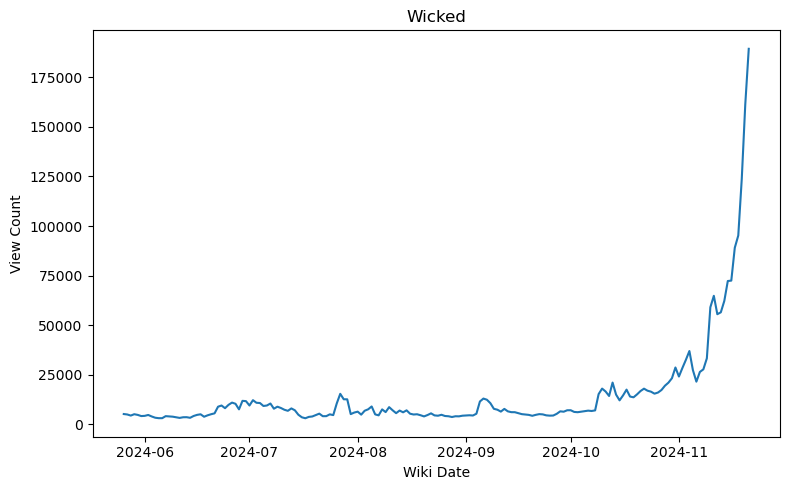

In [136]:
w1 = wiki_final_metrics_all[wiki_final_metrics_all['title_id'] == '1384'][['title','wiki_date','view_count']]

# Create the plot
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
plt.plot(w1['wiki_date'], w1['view_count'])

# Add labels and title
plt.xlabel("Wiki Date")
plt.ylabel("View Count")
plt.title("Wicked")
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

<Axes: >

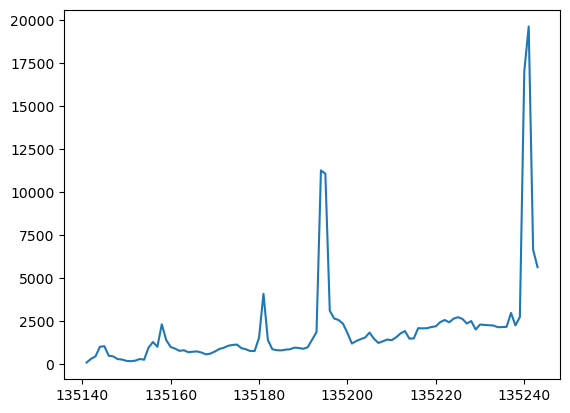

In [234]:
wiki_final_metrics_all[wiki_final_metrics_all['title_id'] == '930196']['view_count'].plot()

<Axes: >

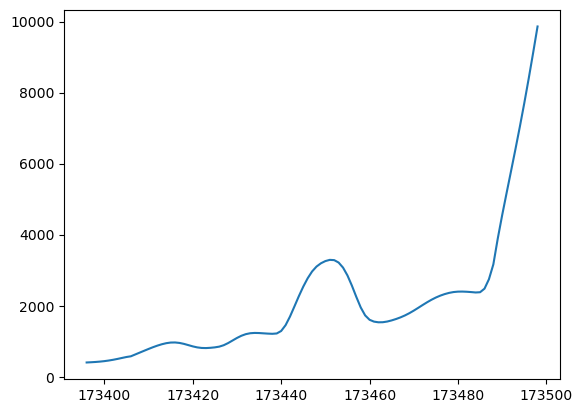

In [235]:
smoothed_df[smoothed_df['title_id'] == '930196']['smoothed_view_count'].plot()

<Axes: >

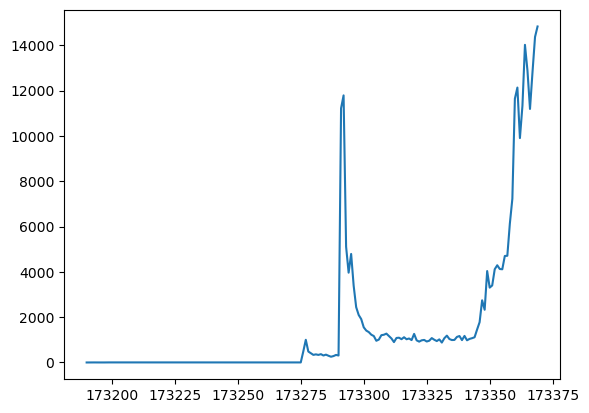

In [52]:
wiki_final_metrics_all[wiki_final_metrics_all['title_id'] == '913308']['view_count'].plot()

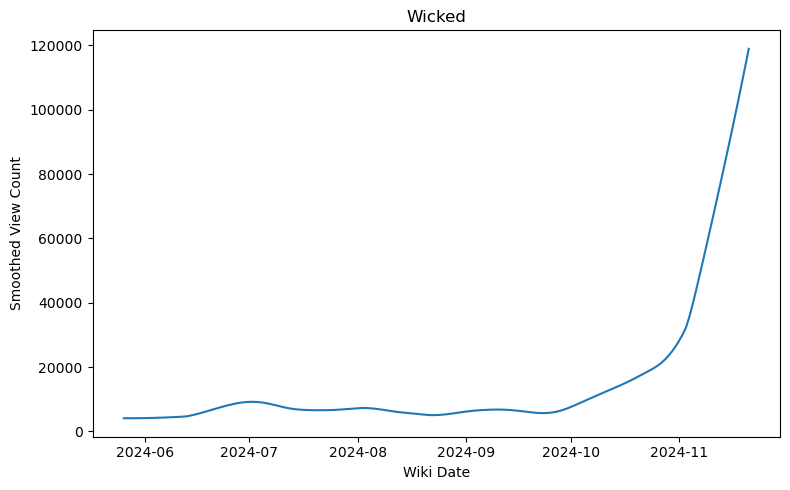

In [140]:
w1 = smoothed_df[smoothed_df['title_id'] == '1384'][['wiki_date','smoothed_view_count']]

# Create the plot
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
plt.plot(w1['wiki_date'], w1['smoothed_view_count'])

# Add labels and title
plt.xlabel("Wiki Date")
plt.ylabel("Smoothed View Count")
plt.title("Wicked")
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

In [37]:
### merge in smooth results...
train_data = pd.merge(train_data, smoothed_df)

print(train_data.title_id.nunique())
train_data.head(3)

868


,title,title_id,wiki_date,days_delta,view_count,edits,edits_cume,view_count_cume,smoothed_view_count
0,10 Cloverfield Lane,169,2015-09-13,-180.0,99.0,0.0,0.0,99.0,92.892668
1,10 Cloverfield Lane,169,2015-09-14,-179.0,100.0,0.0,0.0,199.0,93.795119
2,10 Cloverfield Lane,169,2015-09-15,-178.0,90.0,0.0,0.0,289.0,94.704828


## KMeans clustering

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler,  PowerTransformer
from sklearn.metrics import mean_squared_error,mean_absolute_error
   
def error_function(y_true,y_pred):
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    def mean_absolute_scaled_error(y_true,y_pred):
            return np.mean(np.abs(y_true - y_pred) / np.abs(y_true - np.mean(y_true)))
   
    mase = mean_absolute_scaled_error(y_true,y_pred)
    mase = round(mase, 2)
    mae = round(mae, 2)
    mse = round(mse, 2)   
    outputs = {'mae':mae,'mse':mse,'mase':mase}
    return outputs
    
# print(f"min_max_error: {min_max_error}",f"standard_scaler_error: {standard_scaler_error}",sep='')

In [39]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestCentroid


def silhouette_plot(X, num, model):
    # Generating the sample data from make_blobs
    # This particular setting has one distinct cluster and 3 clusters placed close
    # together.
#     X, y = make_blobs(
#         n_samples=500,
#         n_features=2,
#         centers=4,
#         cluster_std=1,
#         center_box=(-10.0, 10.0),
#         shuffle=True,
#         random_state=1,
#     )  # For reproducibility

#     range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in num:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if model == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto')
        
        elif model == 'kmedoids':
            clusterer = KMedoids(n_clusters=n_clusters, random_state=0)
            
        elif model == 'bisect':
            clusterer = BisectingKMeans(n_clusters=n_clusters, random_state=0)
            
        elif model == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            pd.DataFrame(X).iloc[:, 0], pd.DataFrame(X).iloc[:, 1], marker=".", 
            s=100, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        if model == 'agglomerative':
            y_predict = clusterer.fit_predict(X)

            clf = NearestCentroid()
            clf.fit(X, y_predict)

            centers = clf.centroids_
        
        else:
            centers = clusterer.cluster_centers_
            
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## time series SOM clustering
- view count vs view count cume?

In [43]:
from minisom import MiniSom
from sklearn.preprocessing import normalize
import math
import scipy

In [41]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler

### prepare data
use past 60 days leading up to release for time series clustering

In [49]:
g = pd.RangeIndex(train_data['days_delta'].min(), train_data['days_delta'].max()+1)
mux = pd.MultiIndex.from_product([train_data['title_id'].unique(), g.unique()])

In [50]:
com = train_data.set_index(['title_id','days_delta']).reindex(mux, fill_value=0)[
    [#'view_count','view_count_cume',
     'smoothed_view_count']].reset_index()

# com.loc[com['locs_pct_change'] == np.inf, 'locs_pct_change']=1

## filter days out...60 days
com = com[com['level_1'] >= -60].reset_index(drop=True)

com.head(6)

,level_0,level_1,smoothed_view_count
0,169,-60,25416.671336
1,169,-59,26755.595301
2,169,-58,27869.874612
3,169,-57,28805.565736
4,169,-56,29616.070696
5,169,-55,30348.697060


In [51]:
train_data.columns

Index(['title', 'title_id', 'wiki_date', 'days_delta', 'view_count', 'edits',
       'edits_cume', 'view_count_cume', 'smoothed_view_count'],
      dtype='object')

In [52]:
## latest quality metrics; edits cume, trailer views cume, tracking 
# cume_edits = train_test_df.groupby(['title_id'])[
#     ['edits_cume', 'trailer_view_count_cume', 'definite_interest',
#      'next_movie_will_see_(unaided)','unaided_awareness', ]].last()

cume_edits = train_data.groupby(['title_id'])[
    ['edits_cume']].last()

# scaler = MinMaxScaler()
scaler = StandardScaler()
cume_edits = pd.DataFrame(scaler.fit_transform(cume_edits), index=cume_edits.index, 
                          columns=['edits_cume'])

cume_edits.head(3)

,edits_cume
title_id,
1001,0.733732
1005,-0.102328
1006,1.622047


In [53]:
cume_edits.isna().sum()

edits_cume    0
dtype: int64

In [54]:
## scale smoothed view counts

scaler = StandardScaler()
com_scaled = scaler.fit_transform(com.iloc[:,2:])

In [210]:
# scaler = MinMaxScaler()
# com_scaled = scaler.fit_transform(com.iloc[:,2:])

In [79]:
# com_scaled = normalize(com_scaled)

In [55]:
com_scaled = pd.DataFrame(com_scaled)
com_scaled.columns = com.columns[2:] 

In [56]:
com_scaled = com.iloc[:,:2].join(com_scaled)
com_scaled.head()

,level_0,level_1,smoothed_view_count
0,169,-60,0.825650
1,169,-59,0.897458
2,169,-58,0.957218
3,169,-57,1.007399
4,169,-56,1.050867


In [57]:
com_pivot = pd.pivot(com_scaled, index=['level_0'], columns=['level_1'])
com_pivot.index.name = 'title_id'

com_pivot.columns = [n[0] + '_' + ''.join(str(n[1])) for n in com_pivot.columns]

## add edits
com_pivot = com_pivot.join(cume_edits)

print(com_pivot.shape)
com_pivot.head()

(868, 61)


,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume
title_id,,,,,,,,,,,,,,,,,,,,,
1001,0.471344,0.479976,0.485650,0.487519,0.484076,0.473614,0.454453,0.425122,0.384556,0.332344,...,-0.011600,0.003255,0.018017,0.032642,0.047104,0.061393,0.075518,0.089498,0.103360,0.733732
1005,-0.415826,-0.418571,-0.422344,-0.427124,-0.432817,-0.439250,-0.446172,-0.453265,-0.460143,-0.466365,...,-0.398838,-0.392180,-0.385393,-0.378470,-0.371405,-0.364194,-0.356843,-0.349359,-0.341754,-0.102328
1006,-0.403003,-0.404012,-0.404570,-0.404700,-0.404465,-0.403941,-0.403175,-0.402196,-0.400989,-0.399540,...,0.736499,0.809120,0.882539,0.956717,1.031589,1.107101,1.183221,1.259918,1.337165,1.622047
1009,-0.420063,-0.418064,-0.416048,-0.414074,-0.412173,-0.410355,-0.408610,-0.406899,-0.405207,-0.403546,...,0.140551,0.159638,0.178746,0.197880,0.217047,0.236263,0.255550,0.274931,0.294418,-0.379273
1010,-0.393730,-0.386327,-0.378029,-0.369182,-0.360141,-0.351197,-0.342514,-0.334148,-0.326099,-0.318367,...,0.203166,0.224105,0.245404,0.267096,0.289206,0.311752,0.334747,0.358171,0.381998,0.817338


In [321]:
genres_ = ['Action_Adventure','Animation','Comedy', 'SciFi_Fantasy', 'Drama',
           'Family', 'Foreign', 'Musical', 'Horror_Suspense', 'Romance']

# genres_ = ['Action_Adventure','Comedy','Family', 'Foreign']

In [44]:
# ## train test meta
# ttm = train_test_df[['title_id','franchise', 'season'] + genres_].drop_duplicates()
# ttm.set_index('title_id', inplace=True)

# ttm = ttm.join(pd.get_dummies(ttm['season'], dtype=int))

# ttm.drop(['season'], axis=1, inplace=True)
# ttm.drop(['Fall','Spring','Holiday','Winter'], axis=1, inplace=True)

# print(ttm.shape)
# ttm.head(2)

(999, 12)


,franchise,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Foreign,Musical,Horror_Suspense,Romance,Summer
title_id,,,,,,,,,,,,
848160,0,0.0,0,0,1.0,1,0,0,0,1.0,0,0
871440,0,0.0,0,1,0.0,0,0,1,0,0.0,0,1


In [58]:
# com_pivot_m = com_pivot.join(ttm)
com_pivot_m = com_pivot.copy()

In [59]:
print(com_pivot_m.shape)
com_pivot_m.head()

(868, 61)


,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume
title_id,,,,,,,,,,,,,,,,,,,,,
1001,0.471344,0.479976,0.485650,0.487519,0.484076,0.473614,0.454453,0.425122,0.384556,0.332344,...,-0.011600,0.003255,0.018017,0.032642,0.047104,0.061393,0.075518,0.089498,0.103360,0.733732
1005,-0.415826,-0.418571,-0.422344,-0.427124,-0.432817,-0.439250,-0.446172,-0.453265,-0.460143,-0.466365,...,-0.398838,-0.392180,-0.385393,-0.378470,-0.371405,-0.364194,-0.356843,-0.349359,-0.341754,-0.102328
1006,-0.403003,-0.404012,-0.404570,-0.404700,-0.404465,-0.403941,-0.403175,-0.402196,-0.400989,-0.399540,...,0.736499,0.809120,0.882539,0.956717,1.031589,1.107101,1.183221,1.259918,1.337165,1.622047
1009,-0.420063,-0.418064,-0.416048,-0.414074,-0.412173,-0.410355,-0.408610,-0.406899,-0.405207,-0.403546,...,0.140551,0.159638,0.178746,0.197880,0.217047,0.236263,0.255550,0.274931,0.294418,-0.379273
1010,-0.393730,-0.386327,-0.378029,-0.369182,-0.360141,-0.351197,-0.342514,-0.334148,-0.326099,-0.318367,...,0.203166,0.224105,0.245404,0.267096,0.289206,0.311752,0.334747,0.358171,0.381998,0.817338


In [60]:
## add weights to place more emphasis on latest wiki views, trailer views

# ### for actual implementation will need to be a floating 5-day range (latest)
# com_pivot_m['view_count_-1'] = com_pivot_m['view_count_-1']*10
# com_pivot_m['view_count_-2'] = com_pivot_m['view_count_-2']*10
# com_pivot_m['view_count_-3'] = com_pivot_m['view_count_-3']*5
# com_pivot_m['view_count_-4'] = com_pivot_m['view_count_-4']*5
# com_pivot_m['view_count_-5'] = com_pivot_m['view_count_-5']*5


# com_pivot_m['view_count_cume_-1'] = com_pivot_m['view_count_cume_-1']*10
# com_pivot_m['view_count_cume_-2'] = com_pivot_m['view_count_cume_-2']*10
# com_pivot_m['view_count_cume_-3'] = com_pivot_m['view_count_cume_-3']*5
# com_pivot_m['view_count_cume_-4'] = com_pivot_m['view_count_cume_-4']*5
# com_pivot_m['view_count_cume_-5'] = com_pivot_m['view_count_cume_-5']*5


## more emphasis on the latest view counts
com_pivot_m['smoothed_view_count_-1'] = com_pivot_m['smoothed_view_count_-1']*10
com_pivot_m['smoothed_view_count_-2'] = com_pivot_m['smoothed_view_count_-2']*10
com_pivot_m['smoothed_view_count_-3'] = com_pivot_m['smoothed_view_count_-3']*5
com_pivot_m['smoothed_view_count_-4'] = com_pivot_m['smoothed_view_count_-4']*5
com_pivot_m['smoothed_view_count_-5'] = com_pivot_m['smoothed_view_count_-5']*2


# com_pivot_m['trailer_view_count_cume'] = com_pivot_m['trailer_view_count_cume']*5
# com_pivot_m['edits_cume'] = com_pivot_m['edits_cume']*5
# com_pivot_m['next_movie_will_see_(unaided)'] = com_pivot_m['next_movie_will_see_(unaided)']*10


In [61]:
com_transformed_locs = com_pivot_m
com_transformed_locs.head()

,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume
title_id,,,,,,,,,,,,,,,,,,,,,
1001,0.471344,0.479976,0.485650,0.487519,0.484076,0.473614,0.454453,0.425122,0.384556,0.332344,...,-0.011600,0.003255,0.018017,0.032642,0.094207,0.306964,0.377588,0.894982,1.033598,0.733732
1005,-0.415826,-0.418571,-0.422344,-0.427124,-0.432817,-0.439250,-0.446172,-0.453265,-0.460143,-0.466365,...,-0.398838,-0.392180,-0.385393,-0.378470,-0.742809,-1.820972,-1.784214,-3.493590,-3.417544,-0.102328
1006,-0.403003,-0.404012,-0.404570,-0.404700,-0.404465,-0.403941,-0.403175,-0.402196,-0.400989,-0.399540,...,0.736499,0.809120,0.882539,0.956717,2.063178,5.535507,5.916104,12.599176,13.371654,1.622047
1009,-0.420063,-0.418064,-0.416048,-0.414074,-0.412173,-0.410355,-0.408610,-0.406899,-0.405207,-0.403546,...,0.140551,0.159638,0.178746,0.197880,0.434094,1.181314,1.277752,2.749308,2.944181,-0.379273
1010,-0.393730,-0.386327,-0.378029,-0.369182,-0.360141,-0.351197,-0.342514,-0.334148,-0.326099,-0.318367,...,0.203166,0.224105,0.245404,0.267096,0.578411,1.558762,1.673735,3.581713,3.819981,0.817338


In [234]:
# ## PCA transformer
# from sklearn.decomposition import PCA
# pca = PCA()


# com_transformed_locs = pd.DataFrame(pca.fit_transform(com_pivot_m))
# com_transformed_locs = pd.DataFrame(com_pivot_m.index).join(com_transformed_locs)
# com_transformed_locs.set_index('title_id', inplace=True)

# com_transformed_locs.head()

In [62]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
#                     print(series)
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

### SOM #1

standardscaler, and PCA
- all cols or first 6?
- weights: 3x on week 1 & week 2

#### hyperparameter tuning

In [76]:
print(com_transformed_locs.shape)
com_transformed_locs.head(2)

(868, 61)


,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume
title_id,,,,,,,,,,,,,,,,,,,,,
1001,0.471344,0.479976,0.485650,0.487519,0.484076,0.473614,0.454453,0.425122,0.384556,0.332344,...,-0.011600,0.003255,0.018017,0.032642,0.094207,0.306964,0.377588,0.894982,1.033598,0.733732
1005,-0.415826,-0.418571,-0.422344,-0.427124,-0.432817,-0.439250,-0.446172,-0.453265,-0.460143,-0.466365,...,-0.398838,-0.392180,-0.385393,-0.378470,-0.742809,-1.820972,-1.784214,-3.493590,-3.417544,-0.102328


In [64]:
def som_train(som_x, som_y, sig):
    som = MiniSom(x=som_x, 
            y=som_y,
            input_len = len(mySeries2[0]),
            activation_distance='euclidean',
            sigma=sig,
            learning_rate = .5,
            random_seed=3
           )
    som.train(mySeries2,10000)
    return som

In [65]:
## som_x
np.sqrt(5*np.sqrt(1000))

12.574334296829354

In [78]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

space = {
    'sig': hp.uniform('sig', 0.001, 2),
    'learning_rate': hp.uniform('learning_rate', 0.001, 2)
}

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    
    som = MiniSom(x = som_x,
                  y = som_y,
                  input_len = len(mySeries2[0]),
                  sigma=sig,
                  activation_distance='euclidean', ## euclidean / cosine
                  random_seed=3,
                  learning_rate = learning_rate)
    som.train(mySeries2, 10000)
    
    val = som.quantization_error(mySeries2)
    print(val)
    return {'loss':val, 'status': STATUS_OK}

trials = Trials()

som_x = som_y = 3

# mySeries2 = com_transformed_locs.iloc[:,:6].join(com_transformed_locs.iloc[:,-19:]).to_numpy()
mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)


print("best: {}".format(best))

# for i, trial in enumerate(trials.trials[:2]):
#     print(i, trial)
    
    

5.639692322299273                                                                                                                                                   
4.644902353729945                                                                                                                                                   
5.1404658543820005                                                                                                                                                  
4.272635166006989                                                                                                                                                   
3.775462520232678                                                                                                                                                   
6.18590461915539                                                                                                                                                    
5.13312461

3.8115231337966162                                                                                                                                                  
4.094784620481602                                                                                                                                                   
4.58347353535025                                                                                                                                                    
4.540435010793263                                                                                                                                                   
4.547247623160826                                                                                                                                                   
3.5962778318111104                                                                                                                                                  
4.29312978

3.7973002086308854                                                                                                                                                  
3.86408643632201                                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97trial/s, best loss: 3.5712679134403946]
best: {'learning_rate': 0.1086125410026246, 'sig': 0.7177173860630247}


In [81]:
best['sig']

0.7177173860630247

In [83]:
com_pivot_locs.iloc[:,:6].join(com_pivot_locs.iloc[:,-19:]).columns

ValueError: columns overlap but no suffix specified: Index(['locs_1', 'locs_2', 'locs_3', 'locs_4', 'locs_5', 'locs_6'], dtype='object')

In [82]:
## set up self-organizing maps (SOM)
"""
A rule of thumb to set the size of the grid for a dimensionality
reduction task is that it should contain 5*sqrt(N) neurons
where N is the number of samples in the dataset to analyze.

E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
hence a map 8-by-8 should perform well.
"""

# mySeries2 = com_transformed_locs.to_numpy()
# mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

## use 1st 6 cols = locations, last 19 are all grosses (week, weekend, psa, total)
# mySeries2 = com_transformed_locs.iloc[:,:6].join(com_transformed_locs.iloc[:,-19:]).to_numpy()

mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

# som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries2))))
# som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries2))*5))-3

som_x = som_y = 3 #8
print(som_x)

# som = MiniSom(som_x, som_y,len(mySeries2[0]), sigma=.5, learning_rate = .5, 

# som = MiniSom(som_x, som_y,len(mySeries2[0]), sigma=1.3, learning_rate = .8, 
#             activation_distance='euclidean', random_seed=3)

# sigma = .87,
# learning_rate = 0.33, 


som = MiniSom(som_x, som_y, len(mySeries2[0]), 
                sigma = best['sig'],
                learning_rate = best['learning_rate'], 
            activation_distance='euclidean', random_seed=3)


som.random_weights_init(mySeries2)
som.train(mySeries2, 1000000)#180 * 6 * 500

3


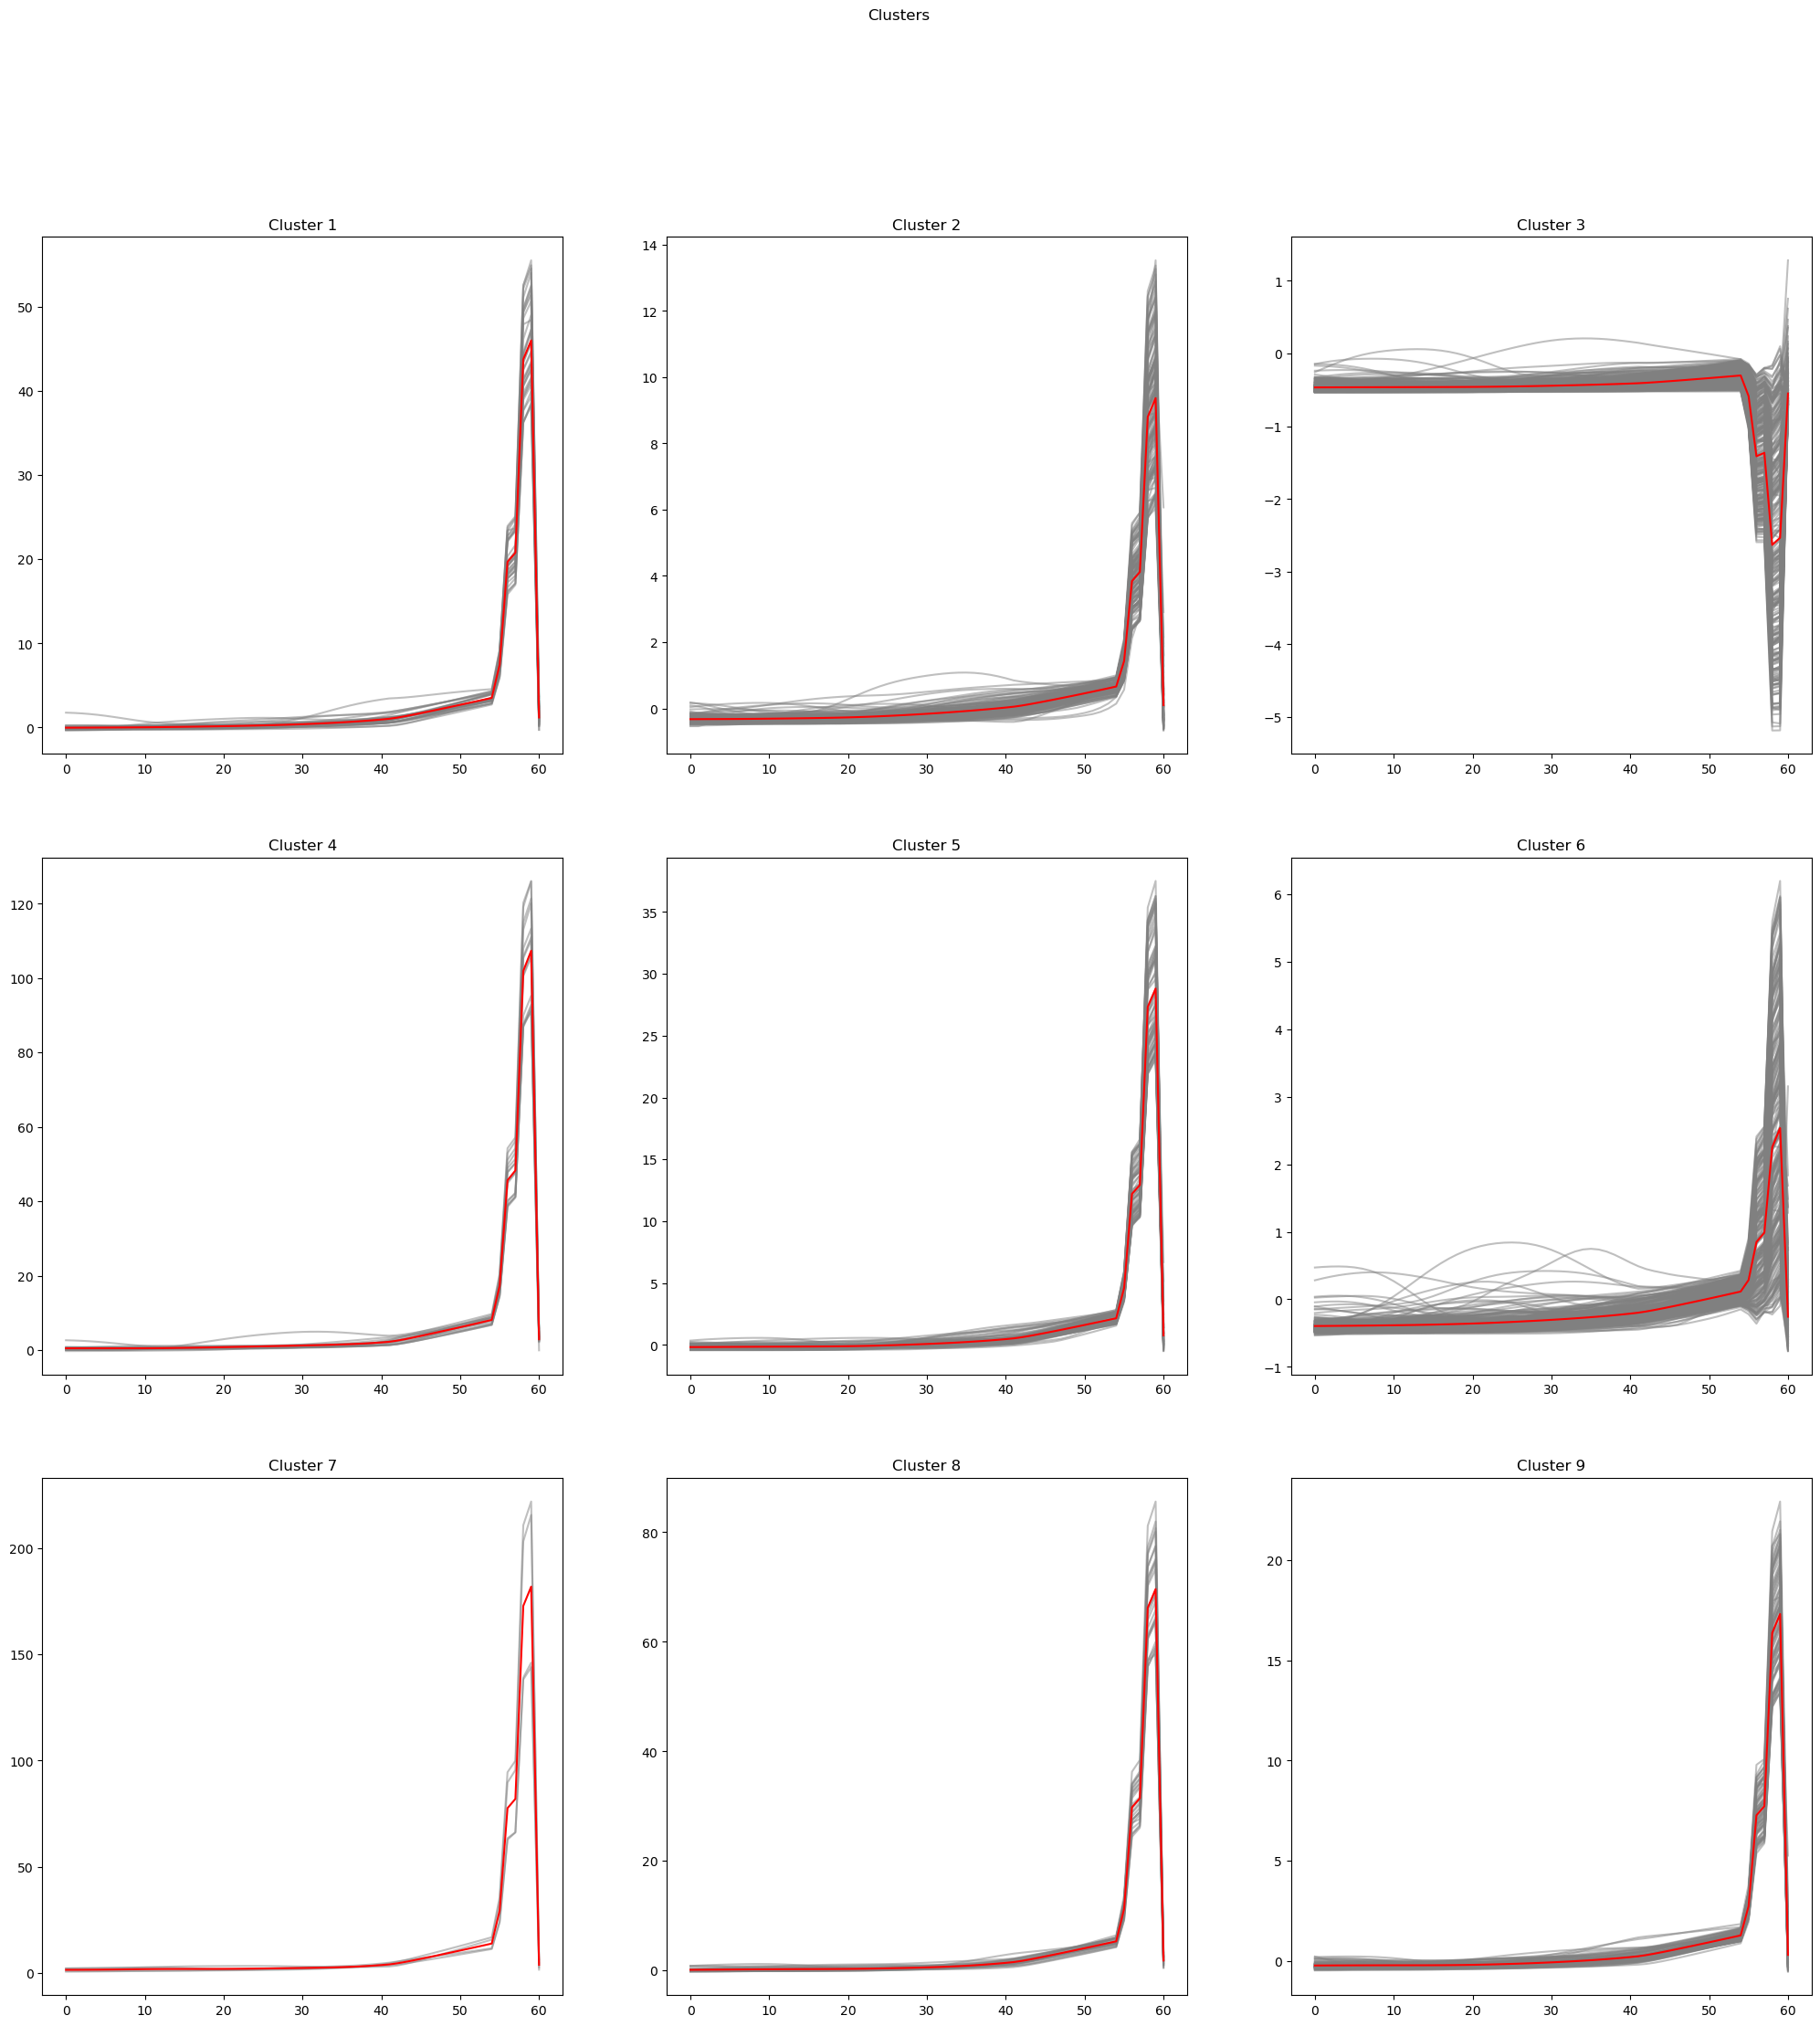

In [83]:
win_map = som.win_map(mySeries2)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [84]:
print('quantization error: ')
som.quantization_error(mySeries2)

quantization error: 


3.710047123883041

In [85]:
cluster_map = []
namesofMySeries = com_transformed_locs.index

for idx in range(len(mySeries2)):
    winner_node = som.winner(mySeries2[idx])
    cluster_map.append((namesofMySeries[idx],f"{winner_node[0]*som_y+winner_node[1]+1}"))
    
cluster_map = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).set_index("Series")

print(cluster_map.shape)
cluster_map.head()

(868, 1)


,Cluster
Series,
1001,6
1005,3
1006,2
1009,6
1010,6


In [162]:
# cluster_map.loc[cluster_map['Cluster'] == '32', 'Cluster'] ='26'

#### find cluster center

In [86]:
## find real centroids
cluster_centers = np.array([vec for center in som.get_weights() 
                            for vec in center])
closest, distances = scipy.cluster.vq.vq(cluster_centers,  mySeries2)

In [87]:
centroids = pd.DataFrame([closest, np.ones(len(closest))]).T
centroids.drop_duplicates(inplace=True)
centroids.columns = ['index', 'centroids']
centroids.set_index('index', inplace=True)

In [88]:
cluster_map = cluster_map.reset_index().join(centroids)
cluster_map.set_index('Series', inplace=True)

print(cluster_map.shape)
cluster_map

(868, 2)


,Cluster,centroids
Series,,
1001,6,NaN
1005,3,NaN
1006,2,NaN
1009,6,NaN
1010,6,NaN
...,...,...
993,3,NaN
994,9,NaN
996,5,NaN


In [89]:
## silhouette score
print('silhouette score: ')
silhouette_score(mySeries2, cluster_map['Cluster'].astype(int).to_numpy())

silhouette score: 


0.5349509120879592

In [90]:
cluster_map['Cluster'].value_counts()

3    304
6    221
2    129
9     75
5     65
1     32
8     24
4     14
7      4
Name: Cluster, dtype: int64

In [161]:
tmp_pivot = pd.pivot_table(com[com['level_0'].isin(cluster_map[cluster_map['Cluster'] == '3'].index)][
    ['level_0', 'level_1', 'smoothed_view_count']], index=['level_0'], columns=['level_1'])

tmp_pivot.columns = [(c[0]) + '_' + str(c[1]) for c in tmp_pivot.columns]
# tmp_pivot = tmp_pivot.join(comscore_23.groupby(['title_id'])[['weekend_gross']].sum())

tmp_pivot = tmp_pivot.join(train_data[['title','title_id']].drop_duplicates().set_index('title_id'))
tmp_pivot.set_index('title', append=True, inplace=True)

tmp_pivot

,,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-10,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1
level_0,title,,,,,,,,,,,,,,,,,,,,,
1005,Red Rocket,2268.091314,2216.911229,2146.555625,2057.430900,1951.275768,1831.328805,1702.263790,1570.010092,1441.763506,1325.739770,...,2462.850657,2584.860566,2709.005986,2835.544738,2964.640690,3096.379970,3230.818258,3367.898881,3507.441906,3649.236577
1013,A Journal for Jordan,926.163603,967.405745,1006.016464,1040.797456,1071.002976,1096.462649,1117.451424,1134.415889,1147.991949,1158.992332,...,5113.647479,5188.797897,5263.958767,5339.406089,5415.417340,5492.249289,5570.127401,5649.234041,5729.711726,5811.625801
1019,The Worst Person in the World,1553.582823,1601.136619,1654.069429,1710.866181,1770.400913,1832.306035,1896.570483,1962.930122,2030.871245,2100.134593,...,4236.194448,4299.260610,4363.424031,4428.781414,4495.467338,4563.613902,4633.350508,4704.798854,4778.112757,4853.426550
1023,Blacklight,344.290066,355.718602,368.138563,381.580974,396.092811,411.970772,430.898239,456.216925,490.656183,535.355581,...,3205.822408,3374.461747,3544.730479,3716.620613,3890.229927,4065.756320,4243.471711,4423.677821,4606.673048,4792.681280
1026,Dog,1086.922642,1112.677331,1138.655428,1163.989863,1187.973013,1210.043691,1229.795982,1246.980687,1261.479197,1273.368416,...,6262.504221,6576.919456,6894.438840,7215.588800,7540.916720,7870.971300,8206.096248,8546.422139,8891.976010,9242.722610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,The Card Counter,429.239958,471.846473,530.655607,603.383919,686.156516,774.506263,864.008221,950.813198,1031.768028,1104.589566,...,3050.041697,3253.969726,3460.725672,3670.707865,3884.147931,4101.081528,4321.478747,4545.294123,4772.486098,5002.985725
980,The Eyes of Tammy Faye,963.971867,968.373107,974.802099,983.366060,993.755582,1005.426086,1017.584907,1029.327987,1039.950488,1048.951264,...,6501.824976,6885.872664,7273.923682,7666.562142,8064.313230,8467.718596,8877.381242,9293.862179,9717.385702,10147.942733
981,Titane,3678.986415,3051.524293,2643.583921,2398.473614,2232.771298,2105.652810,2004.385824,1924.063091,1861.311249,1811.785364,...,4524.955316,4755.231692,4986.626154,5219.522490,5454.317565,5691.431995,5931.344513,6174.581217,6421.631945,6672.845642


In [164]:
tmp_pivot.index.get_level_values('title').tolist()

['Red Rocket',
 'A Journal for Jordan',
 'The Worst Person in the World',
 'Blacklight',
 'Dog',
 'The Cursed',
 'Alice (2022)',
 'The Outfit',
 'Memory',
 "Bob's Burgers Movie, The",
 'Marcel the Shell with Shoes On',
 "Mr. Malcolm's List",
 'Mrs. Harris Goes To Paris',
 'Gone in the Night',
 'Vengeance',
 'Bodies Bodies Bodies',
 'Emily the Criminal',
 'Triangle of Sadness',
 'Lyle, Lyle, Crocodile',
 'Till',
 'Aftersun',
 'Prey for the Devil',
 'Armageddon Time',
 'The Inspection',
 'She Said',
 'All the Beauty and the Bloodshed',
 'Empire of Light',
 'Plane',
 'Close',
 'Marlowe',
 'Emily',
 'Jesus Revolution',
 'Champions',
 'Moving On',
 'Thousand and One, A',
 'How to Blow Up a Pipeline',
 "Are You There God? It's Me, Margaret.",
 'Polite Society',
 'BlackBerry',
 'Sanctuary',
 'You Hurt My Feelings',
 'About My Father',
 'Kandahar',
 'Machine, The',
 'Past Lives',
 'Blackening, The',
 'Theater Camp',
 'Jules',
 'Golda',
 'It Lives Inside',
 'Dicks: The Musical',
 'The Royal Hot

In [103]:
som_clusters =  pd.merge(train_data, cluster_map.reset_index(), left_on='title_id', right_on='Series').drop(['Series'], axis=1)
print(som_clusters.shape)
som_clusters.head()

(152861, 11)


,title,title_id,wiki_date,days_delta,view_count,edits,edits_cume,view_count_cume,smoothed_view_count,Cluster,centroids
0,10 Cloverfield Lane,169,2015-09-13,-180.0,99.0,0.0,0.0,99.0,92.892668,8,NaN
1,10 Cloverfield Lane,169,2015-09-14,-179.0,100.0,0.0,0.0,199.0,93.795119,8,NaN
2,10 Cloverfield Lane,169,2015-09-15,-178.0,90.0,0.0,0.0,289.0,94.704828,8,NaN
3,10 Cloverfield Lane,169,2015-09-16,-177.0,89.0,0.0,0.0,378.0,95.620749,8,NaN
4,10 Cloverfield Lane,169,2015-09-17,-176.0,105.0,3.0,3.0,483.0,96.542009,8,NaN


In [153]:
s1 = som_clusters.groupby(['Cluster','title_id'])[['view_count_cume']].last()
s1.reset_index(inplace=True)


s1.groupby(['Cluster'])[['view_count_cume']].count()['view_count_cume']

Cluster
1     32
2    129
3    304
4     14
5     65
6    221
7      4
8     24
9     75
Name: view_count_cume, dtype: int64

In [104]:
som_clusters.set_index('title').to_csv('wiki_views_som_clusters_2025-05-10.csv')

### other cluster testing...

SOM cluster #2

In [10224]:
def som_train(som_x, som_y, sig):
    som = MiniSom(x=som_x, 
            y=som_y,
            input_len = len(mySeries2[0]),
            activation_distance='euclidean',
            sigma=sig,
            learning_rate = .5,
            random_seed=3
           )
    som.train(mySeries2,10000)
    return som

In [10225]:
som_x = som_y = 8

best = fmin(
    fn=lambda sig: som_train(som_x, som_y, sig).quantization_error(mySeries2), # Objective Function to optimize
    space=hp.uniform('sig', 0.001, som_x / 2.01), # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm
    max_evals=200) # Number of optimization attempts


print(best)

100%|██████| 200/200 [01:00<00:00,  3.31trial/s, best loss: 0.16793390753284856]
{'sig': 0.9267360754806422}


In [369]:
from hyperopt import Trials, STATUS_OK

space = {
    'sig': hp.uniform('sig', 0.001, 3),
    'learning_rate': hp.uniform('learning_rate', 0.001, 3)
}

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    
    som = MiniSom(x = som_x,
                  y = som_y,
                  input_len = len(mySeries2[0]),
                  sigma=sig,
                  activation_distance='euclidean',
                  random_seed=3,
                  learning_rate = learning_rate)
    som.train(mySeries2, 10000)
    
    val = som.quantization_error(mySeries2)
    print(val)
    return {'loss':val, 'status': STATUS_OK}

trials = Trials()

mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()
som_x = som_y = 7

best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=1000,
           trials=trials)


print("best: {}".format(best))

# for i, trial in enumerate(trials.trials[:1]):
#     print(i, trial)
    
    

0.29491962637349983                                                                                                                                                                                                          
0.2729941593127851                                                                                                                                                                                                           
0.2603353266165926                                                                                                                                                                                                           
0.25691185047164916                                                                                                                                                                                                          
0.303102906805756                                                                                               

0.24570607105325418                                                                                                                                                                                                          
0.2375528614718968                                                                                                                                                                                                           
0.21823728795053865                                                                                                                                                                                                          
0.2127985459665687                                                                                                                                                                                                           
0.37016731784827417                                                                                             

0.2302018969831825                                                                                                                                                                                                           
0.2114363714893812                                                                                                                                                                                                           
0.20880119721240684                                                                                                                                                                                                          
0.21688279384353273                                                                                                                                                                                                          
0.22215125617105086                                                                                             

0.33628957464953557                                                                                                                                                                                                          
0.24428550523269604                                                                                                                                                                                                          
0.2935612797452562                                                                                                                                                                                                           
0.2360978209814712                                                                                                                                                                                                           
0.23856178367055242                                                                                             

0.2198618153539689                                                                                                                                                                                                           
0.27313801542046934                                                                                                                                                                                                          
0.2406981051669983                                                                                                                                                                                                           
0.2109506359096487                                                                                                                                                                                                           
0.2352544969942219                                                                                              

0.23705853326327322                                                                                                                                                                                                          
0.21474683609007644                                                                                                                                                                                                          
1.262017027324532                                                                                                                                                                                                            
0.22260042065250119                                                                                                                                                                                                          
0.22028803393119772                                                                                             

0.21514514087499706                                                                                                                                                                                                          
0.22797195862409503                                                                                                                                                                                                          
0.28218966442329324                                                                                                                                                                                                          
0.22345909830981728                                                                                                                                                                                                          
0.4108217825535417                                                                                              

0.21499639266943932                                                                                                                                                                                                          
0.2139276660343654                                                                                                                                                                                                           
0.22151496164713466                                                                                                                                                                                                          
0.3142236085906915                                                                                                                                                                                                           
0.2268887499614192                                                                                              

0.42041440517796563                                                                                                                                                                                                          
0.21062084155550917                                                                                                                                                                                                          
0.21087004732066486                                                                                                                                                                                                          
0.2096583004925214                                                                                                                                                                                                           
0.2079996079885463                                                                                              

0.2185543896761225                                                                                                                                                                                                           
0.22096033745654822                                                                                                                                                                                                          
0.22995190400871723                                                                                                                                                                                                          
0.2393644503136294                                                                                                                                                                                                           
0.30207980664466266                                                                                             

0.2709117621395782                                                                                                                                                                                                           
0.2876924070525983                                                                                                                                                                                                           
0.21810909188505465                                                                                                                                                                                                          
0.4311349285330962                                                                                                                                                                                                           
0.21497638787713524                                                                                             

0.21749121883635236                                                                                                                                                                                                          
0.21239978609014315                                                                                                                                                                                                          
0.20730632985412822                                                                                                                                                                                                          
0.21718577649942794                                                                                                                                                                                                          
0.21509164461385058                                                                                             

0.21358187550607022                                                                                                                                                                                                          
0.20838306483554542                                                                                                                                                                                                          
0.23624175632848674                                                                                                                                                                                                          
0.22680916481465335                                                                                                                                                                                                          
0.21805069322432652                                                                                             

0.4220885737063088                                                                                                                                                                                                           
0.25095493915635125                                                                                                                                                                                                          
0.2150541123996421                                                                                                                                                                                                           
0.21825298178225833                                                                                                                                                                                                          
0.2199172732922024                                                                                              

In [386]:
## set up self-organizing maps (SOM)
"""
A rule of thumb to set the size of the grid for a dimensionality
reduction task is that it should contain 5*sqrt(N) neurons
where N is the number of samples in the dataset to analyze.

E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
hence a map 8-by-8 should perform well.
"""

# mySeries2 = com_transformed_locs.to_numpy()
mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

som_x = som_y = 8
print(som_x)

##.84,.31, 
som_2 = MiniSom(som_x, som_y, len(mySeries2[0]), 
                sigma=.879,
                learning_rate =.165, 
            activation_distance='euclidean', random_seed=3)


som_2.random_weights_init(mySeries2)
som_2.train(mySeries2, 1000000) #180 * 6 * 500

8


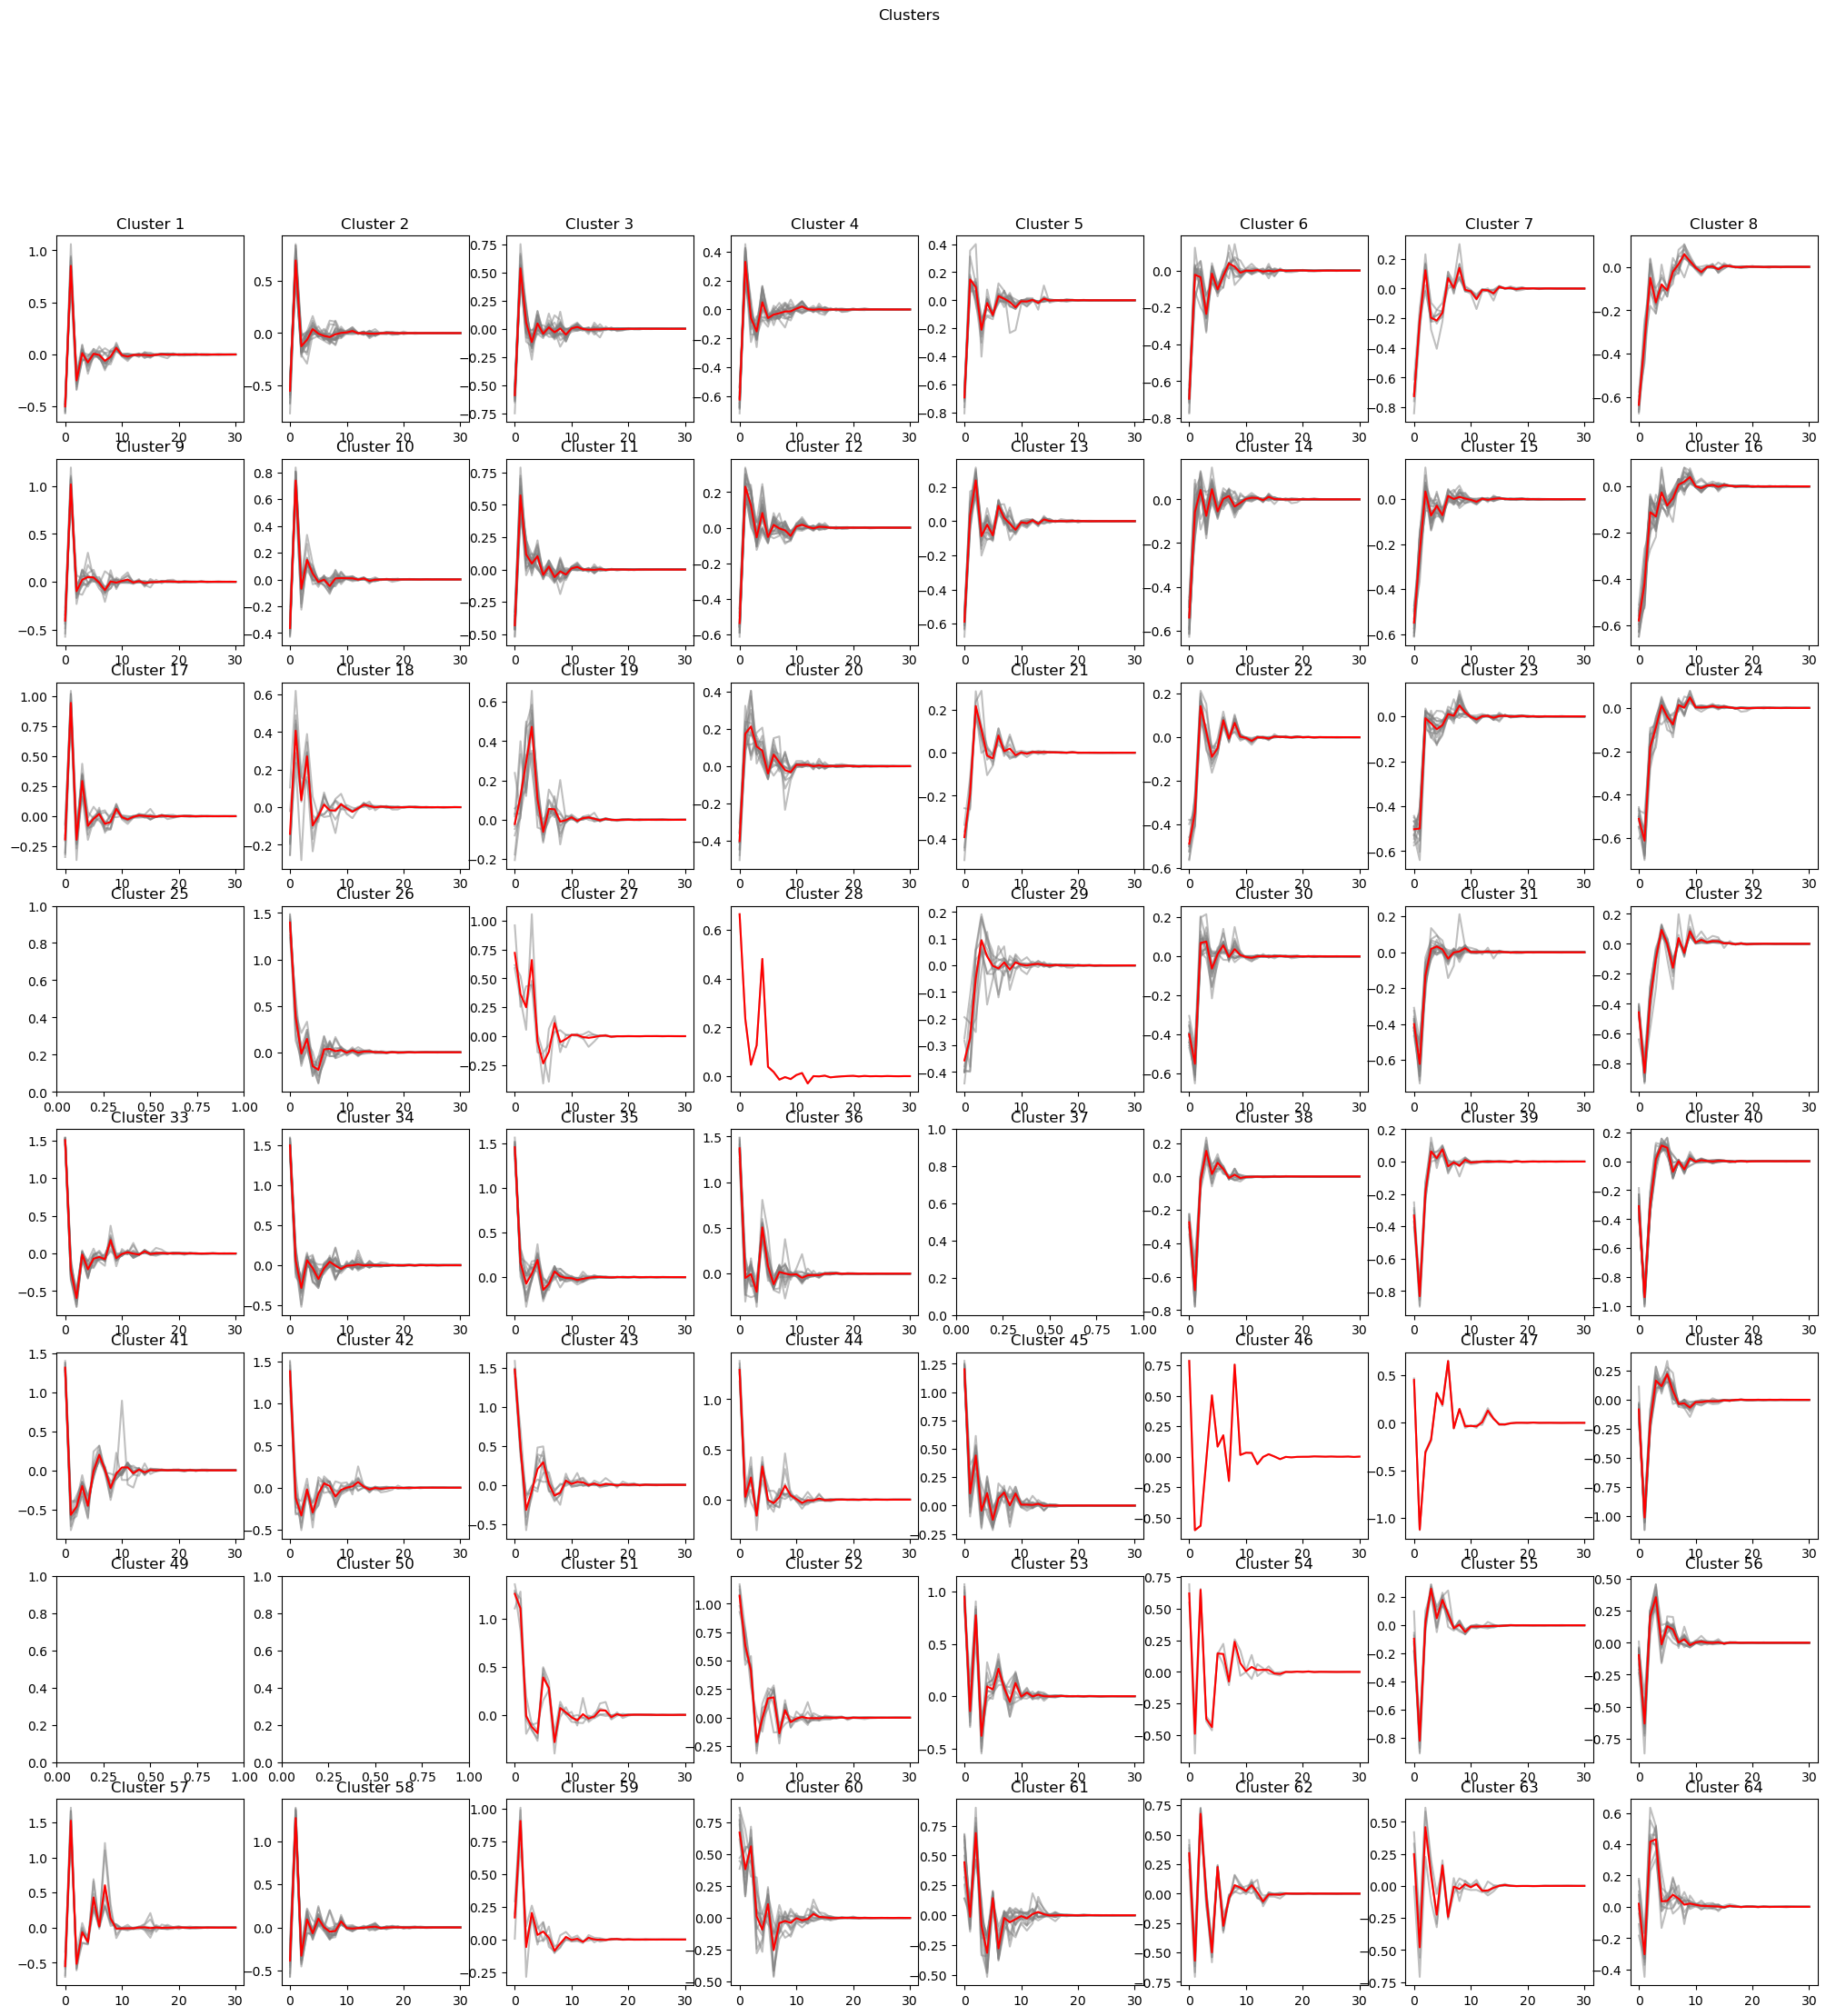

In [387]:
win_map = som_2.win_map(mySeries2)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [388]:
print('quantization error: ')
som_2.quantization_error(mySeries2)

quantization error: 


0.19116124364518375

In [389]:
cluster_map2 = []
namesofMySeries = com_transformed_locs.index

for idx in range(len(mySeries2)):
    winner_node = som_2.winner(mySeries2[idx])
    cluster_map2.append((namesofMySeries[idx],f"{winner_node[0]*som_y+winner_node[1]+1}"))
    
cluster_map2 = pd.DataFrame(cluster_map2,columns=["Series","Cluster"]).set_index("Series")
cluster_map2.head()

,Cluster
Series,
10 cloverfield lane_par,2
12 strong_wb,12
"15:17 to paris, the_wb",13
20th century women_a24,36
21 bridges_stx,13


In [390]:
## silhouette score
print('silhouette score: ')
silhouette_score(mySeries2, cluster_map2['Cluster'].astype(int).to_numpy())

silhouette score: 


0.2316973698585622

#### find cluster center

In [391]:
## find real centroids
cluster_centers = np.array([vec for center in som_2.get_weights() 
                            for vec in center])
closest, distances = scipy.cluster.vq.vq(cluster_centers,  mySeries2)


In [392]:
cluster_map2["centroids"] = 0
for i in closest:
    cluster_map2["centroids"].iloc[i] = 1

cluster_map2.head()

/var/folders/k1/f4f32x596mld7b797nvx032w0000gn/T/ipykernel_99001/2551162804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_map2["centroids"].iloc[i] = 1


,Cluster,centroids
Series,,
10 cloverfield lane_par,2,0
12 strong_wb,12,0
"15:17 to paris, the_wb",13,1
20th century women_a24,36,0
21 bridges_stx,13,0


In [393]:
print(cluster_map2['Cluster'].nunique())
cluster_map2['Cluster'].value_counts()

60


40    24
34    22
2     22
14    21
12    21
3     20
16    20
11    20
4     18
31    17
15    17
58    17
10    16
13    16
23    16
30    16
36    16
56    15
35    15
33    15
48    15
61    14
24    14
20    14
45    14
6     14
5     13
9     13
1     13
60    12
32    12
38    12
41    12
22    11
26    11
29    10
53    10
8     10
64    10
19    10
17    10
42     9
57     8
39     8
55     8
44     8
52     7
62     7
18     7
43     7
7      7
21     7
59     4
63     4
51     4
27     3
54     2
47     2
28     1
46     1
Name: Cluster, dtype: int64

In [410]:
pd.pivot_table(com[com['level_0'].isin(cluster_map2[cluster_map2['Cluster'].isin(['63'])].index)][
    ['level_0','locs', 'level_1', 'psa']], index=['level_0'], columns=['level_1']).join(
    comscore_23.groupby(['title_distributor'])['week_gross'].sum()).head(60)

/var/folders/k1/f4f32x596mld7b797nvx032w0000gn/T/ipykernel_99001/2093411201.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ['level_0','locs', 'level_1', 'psa']], index=['level_0'], columns=['level_1']).join(


,"(locs, 1)","(locs, 2)","(locs, 3)","(locs, 4)","(locs, 5)","(locs, 6)","(psa, 1)","(psa, 2)","(psa, 3)","(psa, 4)","(psa, 5)","(psa, 6)",week_gross
level_0,,,,,,,,,,,,,
empire of light_sl,110,436,350,300,120,48,1485.500000,512.513761,246.420000,394.813333,439.666667,424.687500,1161747
hands of stone_twc,810,2011,1103,105,22,53,2162.207407,628.373943,158.805984,233.961905,275.136364,331.433962,4710125
moonage daydream_neon,170,733,675,290,198,86,7236.147059,1233.422920,663.082963,586.524138,565.212121,477.965116,4180309
stop making sense remastered_a24,264,786,527,258,89,70,3245.443182,1335.720102,844.047438,662.934109,0.000000,691.642857,4261531


In [399]:
cluster_map2[cluster_map2.index.str.contains('eileen|asteroid|terrifier|armagedd|lico|they shall|pandas/'
                                             '|detroit|molly|lady bird|pandas|whale|when')]

,Cluster,centroids
Series,,
armageddon time_foc,62,0
asteroid city_foc,61,0
detroit_apr,61,0
eileen_neon,62,0
lady bird_a24,42,0
licorice pizza_uar,41,0
molly's game_stx,61,0
pandas_wb,27,0
terrifier 2_icoc,28,1


In [408]:
som_clusters2 =  pd.merge(comscore_23, cluster_map2.reset_index(), left_on='title_distributor', right_on='Series').drop(['Series'], axis=1)
som_clusters2.head()

,title,distributor,rating,week,week_num,locs,overall_rank,weekend_gross,week_gross,cume,avg_loc,title_distributor,locs_diff,locs_pct_change,locs_max,locs_prop,week_1_loc,expansion,Cluster,centroids
0,10 Cloverfield Lane,PAR,PG13,2016-03-11,1,3391,2,24727437,32676639,32676639,7292.07,10 cloverfield lane_par,0.0,0.000,3427,0.989495,3391.0,0.0,2,0
1,10 Cloverfield Lane,PAR,PG13,2016-03-18,2,3427,4,12506539,17334158,50010797,3649.41,10 cloverfield lane_par,36.0,0.011,3427,1.000000,3391.0,0.0,2,0
2,10 Cloverfield Lane,PAR,PG13,2016-03-25,3,2802,6,5940154,8802263,58813060,2119.96,10 cloverfield lane_par,-625.0,-0.182,3427,0.817625,3391.0,0.0,2,0
3,10 Cloverfield Lane,PAR,PG13,2016-04-01,4,2511,7,4564126,6162480,64975540,1817.65,10 cloverfield lane_par,-291.0,-0.104,3427,0.732711,3391.0,0.0,2,0
4,10 Cloverfield Lane,PAR,PG13,2016-04-08,5,1886,10,2905190,3759141,68734681,1540.39,10 cloverfield lane_par,-625.0,-0.249,3427,0.550336,3391.0,0.0,2,0


In [409]:
som_clusters2.set_index('title').to_csv('theater_rollout_expansion_som_clusters_2024-03-15.csv')

## time series k-means

- minmaxscaler, and PCA
- standardscaler, and PCA

In [108]:
# from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

In [109]:
com_transformed_locs.head(3)

,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-9,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume
title_id,,,,,,,,,,,,,,,,,,,,,
1001,0.471344,0.479976,0.485650,0.487519,0.484076,0.473614,0.454453,0.425122,0.384556,0.332344,...,-0.011600,0.003255,0.018017,0.032642,0.094207,0.306964,0.377588,0.894982,1.033598,0.733732
1005,-0.415826,-0.418571,-0.422344,-0.427124,-0.432817,-0.439250,-0.446172,-0.453265,-0.460143,-0.466365,...,-0.398838,-0.392180,-0.385393,-0.378470,-0.742809,-1.820972,-1.784214,-3.493590,-3.417544,-0.102328
1006,-0.403003,-0.404012,-0.404570,-0.404700,-0.404465,-0.403941,-0.403175,-0.402196,-0.400989,-0.399540,...,0.736499,0.809120,0.882539,0.956717,2.063178,5.535507,5.916104,12.599176,13.371654,1.622047


In [110]:
mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

In [126]:
cluster_count = math.ceil(math.sqrt(len(mySeries2))) 
print(cluster_count)
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

cluster_count=10
print(cluster_count)

30
10


In [127]:
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean", random_state=100 )
labels = km.fit_predict(mySeries2)

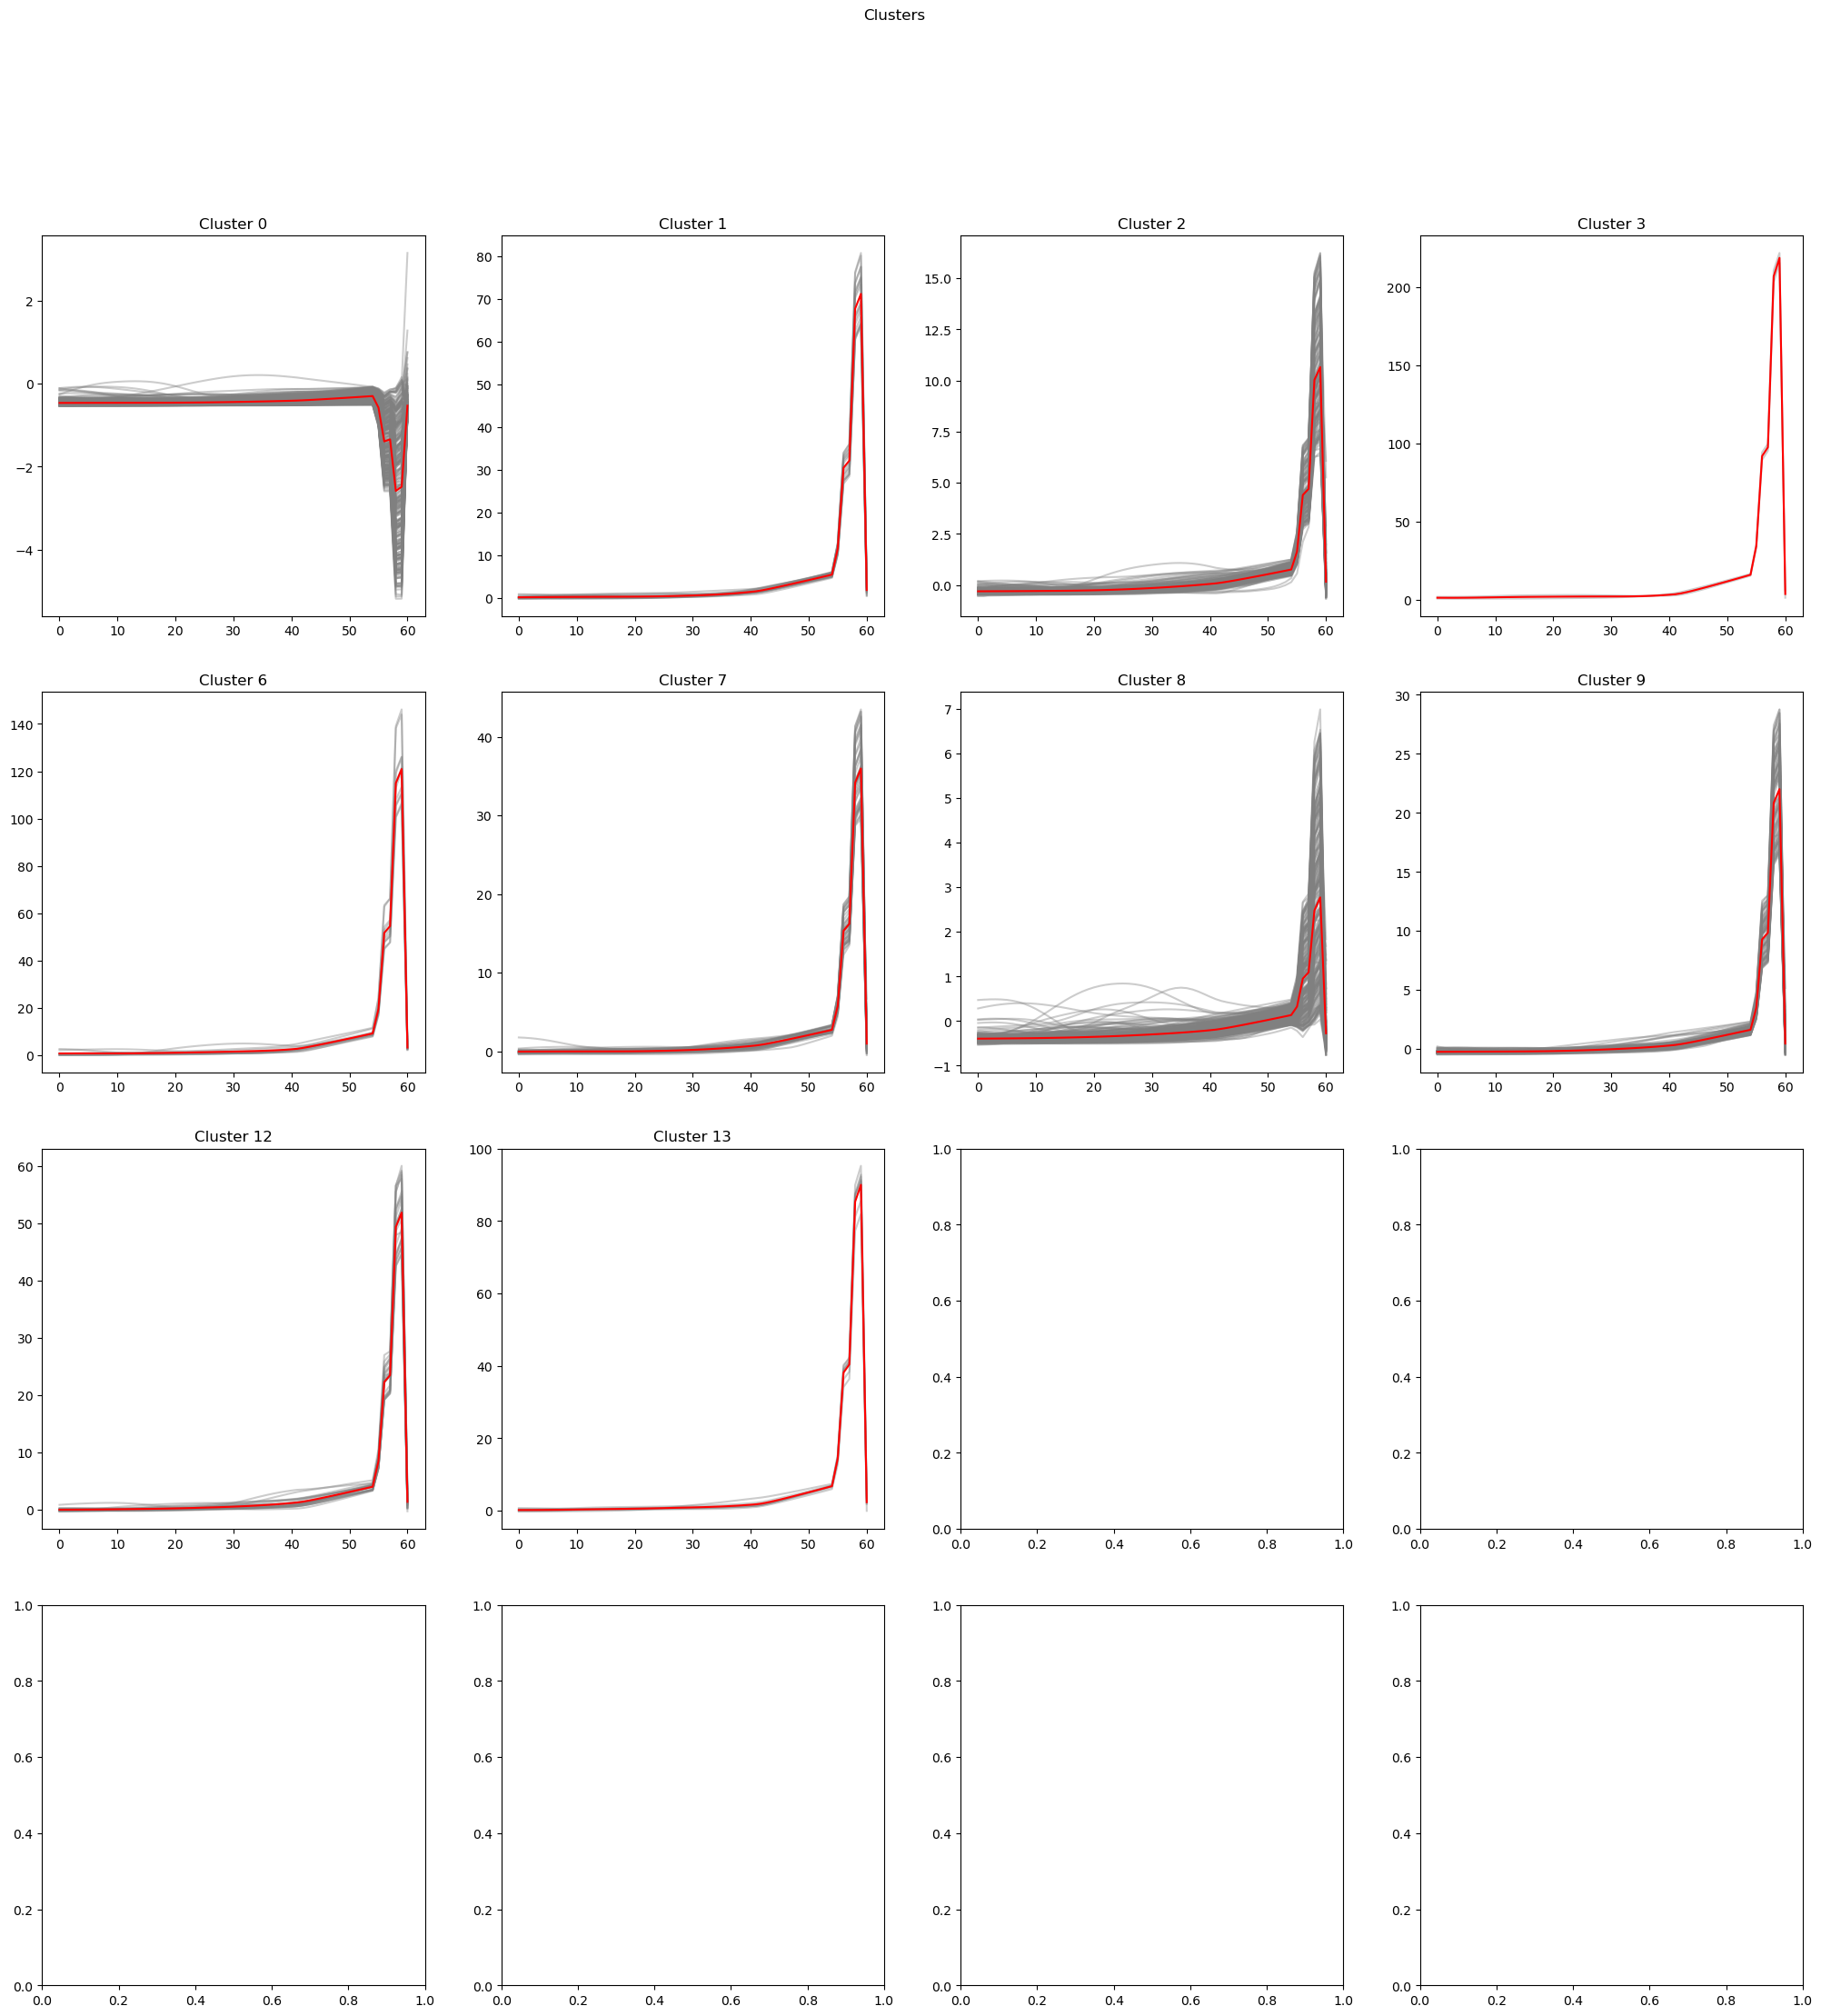

In [128]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
row_n = 6

# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries2[i],c="gray",alpha=0.4)
                cluster.append(mySeries2[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*row_n+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

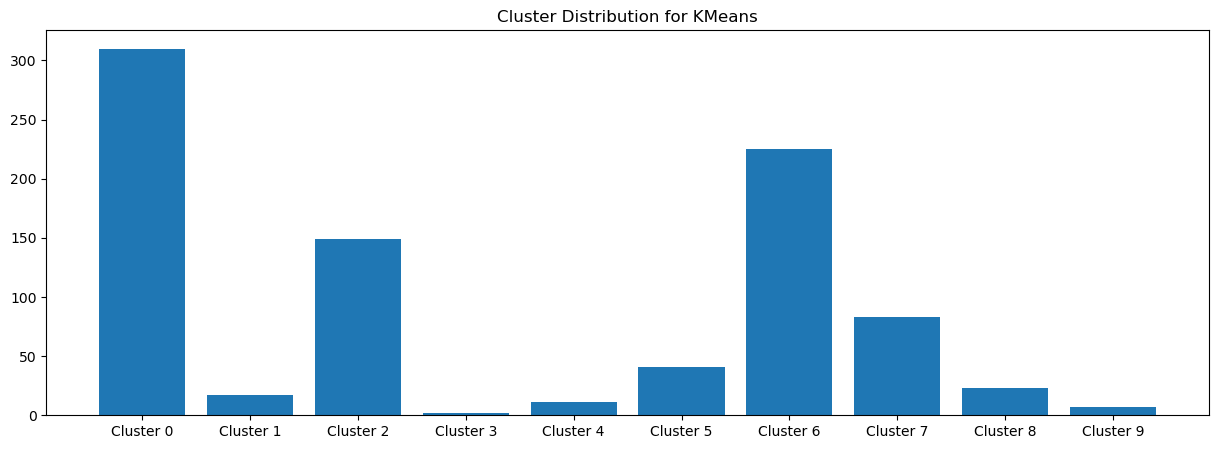

In [129]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [130]:
## silhouette score
print('silhouette score: ')
silhouette_score(mySeries2, labels)

silhouette score: 


0.5360583516538928

In [131]:
pd.DataFrame(labels).value_counts()

0    310
6    225
2    149
7     83
5     41
8     23
1     17
4     11
9      7
3      2
dtype: int64

In [124]:
k_labels = [f"{label}" for label in labels]
namesofMySeries = com_transformed_locs.index

cluster_map3 = pd.DataFrame(zip(namesofMySeries,k_labels),columns=["Series","Cluster"]).set_index("Series")

In [125]:
pd.pivot_table(com[com['level_0'].isin(cluster_map3[cluster_map3['Cluster'] == '3'].index)][
    ['level_0', 'smoothed_view_count', 'level_1']], index=['level_0'], columns=['level_1']).head(50)

smoothed_view_count                                            \
level_1                 -60           -59           -58           -57   
level_0                                                                 
1178           27981.229384  27220.141771  26740.083023  26565.172661   
537            48812.030946  48981.795823  49117.214678  49375.482297   

                                                                               \
level_1           -56           -55           -54           -53           -52   
level_0                                                                         
1178     26657.535102  26902.655962  27205.777119  27518.329217  27811.760036   
537      49887.909393  50730.720997  51921.454972  53432.357546  55200.511195   

                       ...                                               \
level_1           -51  ...            -10            -9             -8    
level_0                ...                                                
1178     28069.723008  ...  246933.537689  265640.013058  284552.047785   
537      57131.137018  ...  220457.669334  240569.026433  260834.025833   

                                                                     \
level_1            -7             -6             -5             -4    
level_0                                                               
1178     303683.925166  323050.642245  342666.413879  362548.272021   
537      281293.034711  302003.912124  323039.360137  344485.007644   

                                                      
level_1            -3             -2             -1   
level_0                                               
1178     382718.004888  403202.219475  424026.886875  
537      366436.740707  388992.332780  412228.074252  

[2 rows x 60 columns]

In [264]:
cluster_map3[cluster_map3.index.str.contains('eileen|asteroid|terrifier|armagedd|licorice|pandas|'
                                             'saving')]

,Cluster
Series,
armageddon time_foc,49
asteroid city_foc,30
eileen_neon,49
licorice pizza_uar,40
pandas_wb,37
terrifier 2_icoc,22
when you finish saving the world_a24,26


In [405]:
tskm_clusters =  pd.merge(train_test_df, cluster_map3.reset_index(), left_on='title_id', right_on='Series').drop(['Series'], axis=1)
print(tskm_clusters.shape)
tskm_clusters.head()

(173499, 23)


,title,title_id,wiki_date,days_delta,view_count,edits,locs_1,edits_cume,season,franchise,...,Comedy,SciFi_Fantasy,Drama,Musical,Family,Foreign,Horror_Suspense,Romance,train_test,Cluster
0,10 Cloverfield Lane,848160,2015-09-13,-180.0,99.0,0.0,3391.0,0.0,Spring,0,...,0,1.0,1,0,0,0,1.0,0,train,9
1,10 Cloverfield Lane,848160,2015-09-14,-179.0,100.0,0.0,3391.0,0.0,Spring,0,...,0,1.0,1,0,0,0,1.0,0,train,9
2,10 Cloverfield Lane,848160,2015-09-15,-178.0,90.0,0.0,3391.0,0.0,Spring,0,...,0,1.0,1,0,0,0,1.0,0,train,9
3,10 Cloverfield Lane,848160,2015-09-16,-177.0,89.0,0.0,3391.0,0.0,Spring,0,...,0,1.0,1,0,0,0,1.0,0,train,9
4,10 Cloverfield Lane,848160,2015-09-17,-176.0,105.0,3.0,3391.0,3.0,Spring,0,...,0,1.0,1,0,0,0,1.0,0,train,9


In [8608]:
# tskm_clusters.set_index('title').to_csv('theater_rollout_expansion_timeserieskmeans_clusters.csv')

## dtaidistance k-means
-- long time to run (50 mins)

In [190]:
# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.clustering import TimeSeriesKMeans
from dtaidistance.preprocessing import differencing
from dtaidistance.clustering import KMeans

In [191]:
com_transformed_locs.head(3)

,smoothed_view_count_-60,smoothed_view_count_-59,smoothed_view_count_-58,smoothed_view_count_-57,smoothed_view_count_-56,smoothed_view_count_-55,smoothed_view_count_-54,smoothed_view_count_-53,smoothed_view_count_-52,smoothed_view_count_-51,...,smoothed_view_count_-8,smoothed_view_count_-7,smoothed_view_count_-6,smoothed_view_count_-5,smoothed_view_count_-4,smoothed_view_count_-3,smoothed_view_count_-2,smoothed_view_count_-1,edits_cume,trailer_view_count_cume
title_id,,,,,,,,,,,,,,,,,,,,,
819418,-0.446274,-0.446626,-0.446864,-0.446905,-0.446679,-0.446163,-0.445378,-0.444376,-0.443229,-0.442015,...,-0.106153,-0.084812,-0.063358,-0.083549,-0.100178,0.009431,0.240159,0.463756,-2.887431,-2.315840
824501,-0.411408,-0.411738,-0.411908,-0.411881,-0.411638,-0.411174,-0.410513,-0.409708,-0.408823,-0.407889,...,-0.056649,-0.039550,-0.022259,-0.009510,0.064881,0.154725,0.491578,0.676193,-0.756225,-1.515298
826168,-0.159041,-0.139277,-0.118632,-0.097231,-0.075010,-0.051726,-0.027101,-0.000935,0.026731,0.055578,...,0.746757,0.754942,0.762654,1.539959,3.885039,3.919103,7.904907,7.970889,5.881596,-0.157036


In [192]:
mySeries2 = com_transformed_locs.iloc[:,:].to_numpy()

In [193]:
## scale data?

dtai_scaler = StandardScaler()
mySeries2 = dtai_scaler.fit_transform(mySeries2)

In [194]:
mySeries2 = differencing(mySeries2, smooth=0.1)

In [196]:
cluster_count = math.ceil(math.sqrt(len(mySeries2))) 
print(cluster_count)

cluster_count = 5

dtai_km = KMeans(k=cluster_count, max_it=10, max_dba_it=10)

27


In [197]:
cluster_idx, performed_it = dtai_km.fit(mySeries2[:500])

{}
0.28177011969207966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:36<00:00, 33.61s/it]


In [198]:
cluster_idx.keys()

dict_keys([0, 1, 2, 3, 4])

In [199]:
dtai_km_labels = pd.DataFrame(cluster_idx.items()).explode(1)
dtai_km_labels.sort_values([1], inplace=True)

dtai_km_labels = dtai_km_labels[0].tolist()

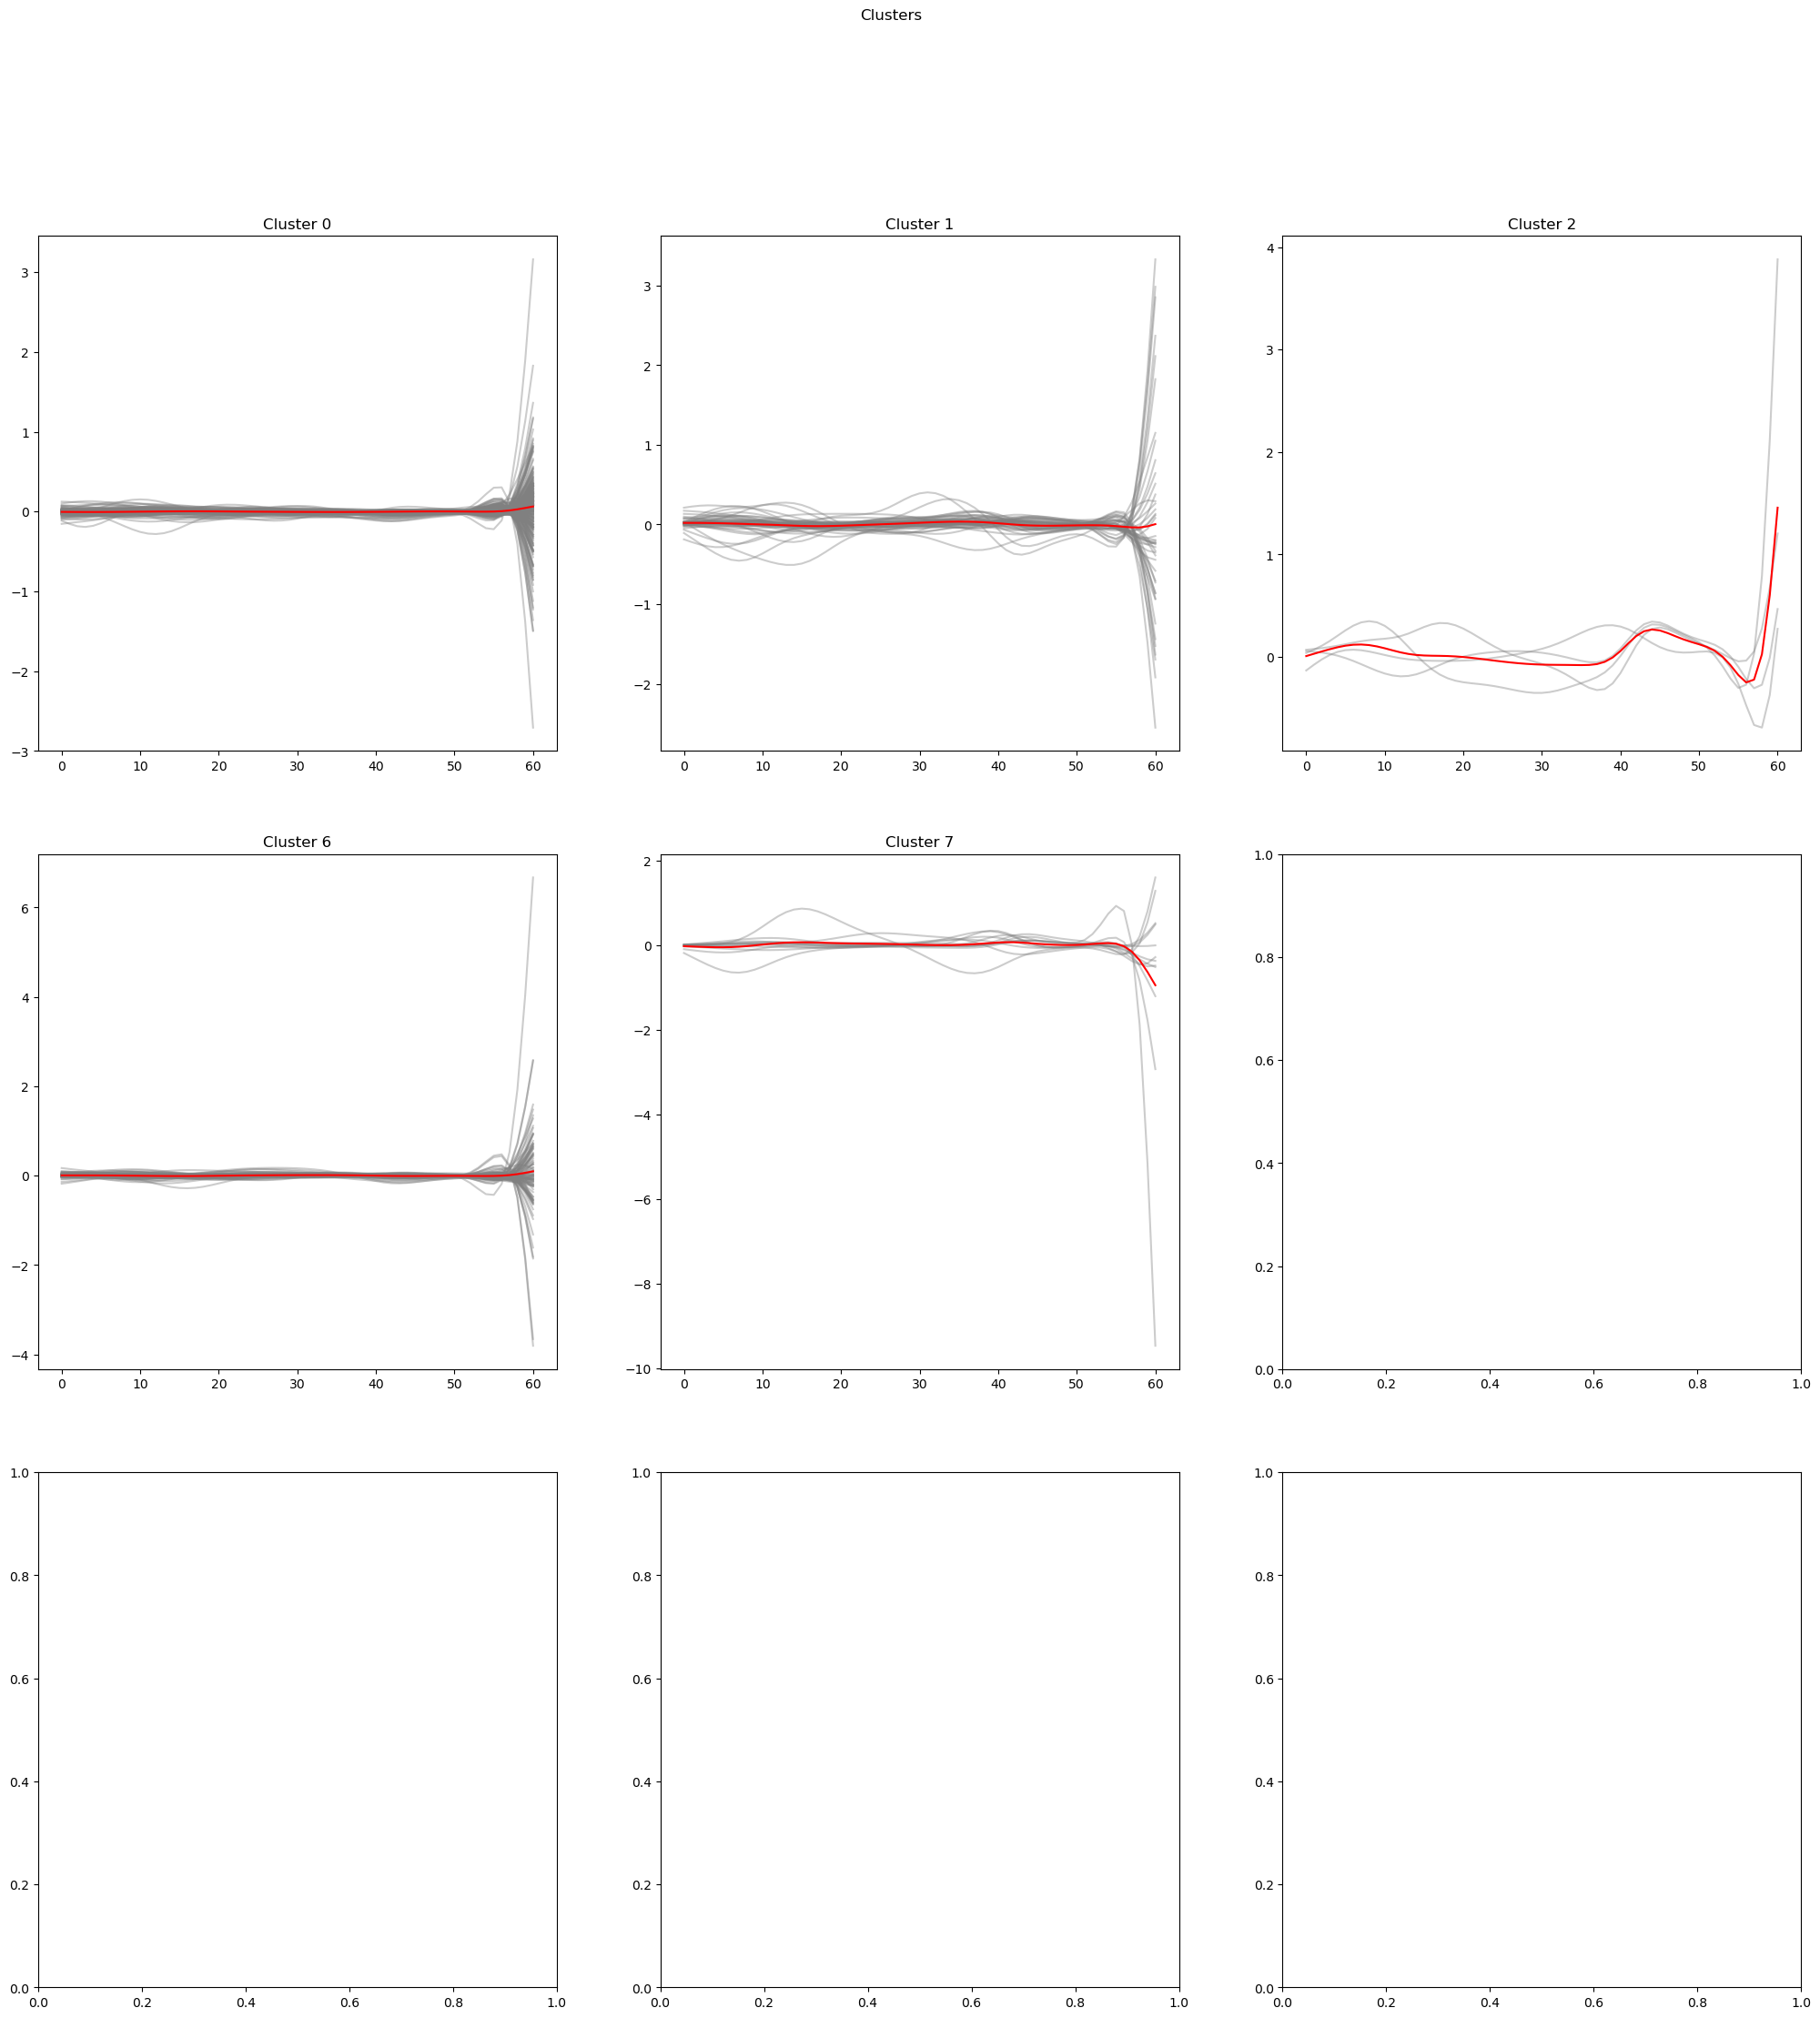

In [200]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
row_n = 6

# For each label there is,
# plots every series with that label
for label in set(dtai_km_labels):
    cluster = []
    for i in range(len(dtai_km_labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries2[i],c="gray",alpha=0.4)
                cluster.append(mySeries2[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*row_n+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [201]:
## silhouette score
print('silhouette score: ')
silhouette_score(mySeries2[:500], dtai_km_labels)

silhouette score: 


0.47841198349258995

In [202]:
pd.DataFrame(dtai_km_labels).value_counts()

0    371
3    108
2     15
4      5
1      1
Name: count, dtype: int64

In [203]:
k_labels = [f"{label}" for label in dtai_km_labels]
namesofMySeries = com_transformed_locs.index

cluster_map4 = pd.DataFrame(zip(namesofMySeries,k_labels),columns=["Series","Cluster"]).set_index("Series")

In [206]:
pd.pivot_table(com[com['level_0'].isin(cluster_map4[cluster_map4['Cluster'] == '1'].index)][
    ['level_0', 'smoothed_view_count', 'level_1']], index=['level_0'], columns=['level_1']).head(50)

smoothed_view_count                                            \
level_1                 -60           -59           -58           -57   
level_0                                                                 
908439         21105.480895  21130.358766  21120.184162  21069.225696   

                                                                              \
level_1           -56           -55           -54           -53          -52   
level_0                                                                        
908439   20975.721256  20843.548511  20681.964207  20503.510053  20323.48015   

                       ...                                               \
level_1           -51  ...            -10            -9             -8    
level_0                ...                                                
908439   20158.448159  ...  124737.435813  136212.928103  147774.862726   

                                                                     \
level_1            -7             -6             -5             -4    
level_0                                                               
908439   159446.122004  171258.945941  183251.733495  195468.681042   

                                                     
level_1            -3            -2             -1   
level_0                                              
908439   207959.530268  220776.49118  233960.544421  

[1 rows x 60 columns]

In [264]:
cluster_map3[cluster_map3.index.str.contains('eileen|asteroid|terrifier|armagedd|licorice|pandas|'
                                             'saving')]

,Cluster
Series,
armageddon time_foc,49
asteroid city_foc,30
eileen_neon,49
licorice pizza_uar,40
pandas_wb,37
terrifier 2_icoc,22
when you finish saving the world_a24,26


In [207]:
dtai_km_clusters =  pd.merge(train_test_df, cluster_map4.reset_index(), left_on='title_id', right_on='Series').drop(['Series'], axis=1)
print(dtai_km_clusters.shape)
dtai_km_clusters.head()

(88222, 27)


,title,title_id,wiki_date,days_delta,view_count,edits,locs_1,edits_cume,view_count_cume,trailer_view_count_cume,...,SciFi_Fantasy,Drama,Musical,Family,Foreign,Horror_Suspense,Romance,train_test,smoothed_view_count,Cluster
0,12 Strong,867111,2017-07-23,-180.0,1237.0,0.0,3002.0,0.0,1237.0,NaN,...,0.0,1,0,0,0,0.0,0,train,944.402856,0
1,12 Strong,867111,2017-07-24,-179.0,1134.0,0.0,3002.0,0.0,2371.0,NaN,...,0.0,1,0,0,0,0.0,0,train,929.283049,0
2,12 Strong,867111,2017-07-25,-178.0,898.0,0.0,3002.0,0.0,3269.0,NaN,...,0.0,1,0,0,0,0.0,0,train,914.462556,0
3,12 Strong,867111,2017-07-26,-177.0,865.0,0.0,3002.0,0.0,4134.0,NaN,...,0.0,1,0,0,0,0.0,0,train,899.904766,0
4,12 Strong,867111,2017-07-27,-176.0,819.0,0.0,3002.0,0.0,4953.0,NaN,...,0.0,1,0,0,0,0.0,0,train,885.567541,0


In [209]:
dtai_km_clusters[dtai_km_clusters['Cluster'] =='1']

,title,title_id,wiki_date,days_delta,view_count,edits,locs_1,edits_cume,view_count_cume,trailer_view_count_cume,...,SciFi_Fantasy,Drama,Musical,Family,Foreign,Horror_Suspense,Romance,train_test,smoothed_view_count,Cluster
70162,Deadpool & Wolverine,908439,2024-01-28,-180.0,11998.0,2.0,4210.0,2.0,11998.0,NaN,...,1.0,0,0,0,0,0.0,0,test,13108.554442,1
70163,Deadpool & Wolverine,908439,2024-01-29,-179.0,13200.0,16.0,4210.0,18.0,25198.0,NaN,...,1.0,0,0,0,0,0.0,0,test,15190.357214,1
70164,Deadpool & Wolverine,908439,2024-01-30,-178.0,12484.0,0.0,4210.0,18.0,37682.0,NaN,...,1.0,0,0,0,0,0.0,0,test,17213.281587,1
70165,Deadpool & Wolverine,908439,2024-01-31,-177.0,13767.0,0.0,4210.0,18.0,51449.0,NaN,...,1.0,0,0,0,0,0.0,0,test,19169.597609,1
70166,Deadpool & Wolverine,908439,2024-02-01,-176.0,11314.0,0.0,4210.0,18.0,62763.0,NaN,...,1.0,0,0,0,0,0.0,0,test,21051.389045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70337,Deadpool & Wolverine,908439,2024-07-21,-5.0,85889.0,30.0,4210.0,1916.0,4326879.0,40276129.0,...,1.0,0,0,0,0,0.0,0,test,183251.733495,1
70338,Deadpool & Wolverine,908439,2024-07-22,-4.0,101067.0,70.0,4210.0,1986.0,4427946.0,40807848.0,...,1.0,0,0,0,0,0.0,0,test,195468.681042,1
70339,Deadpool & Wolverine,908439,2024-07-23,-3.0,266242.0,96.0,4210.0,2082.0,4694188.0,41170188.0,...,1.0,0,0,0,0,0.0,0,test,207959.530268,1
70340,Deadpool & Wolverine,908439,2024-07-24,-2.0,474283.0,254.0,4210.0,2336.0,5168471.0,41464205.0,...,1.0,0,0,0,0,0.0,0,test,220776.491180,1
